In [1]:
import csv
import subprocess
import shlex
import json

import numpy as np

from io import StringIO
from matplotlib import pyplot as plt
from scipy.stats import chisquare, norm, combine_pvalues
from IPython.display import display, Markdown
from tqdm import tqdm

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400

def show():
    plt.savefig(f"normal-dispersal.{show.fig_counter}.pdf", dpi='figure', transparent=True, bbox_inches='tight')
    show.fig_counter += 1
    show.plt_show()

show.fig_counter = 0
show.plt_show = plt.show

plt.show = show

In [3]:
target_directory = json.loads(subprocess.run("cargo metadata --format-version 1".split(), capture_output=True).stdout)["target_directory"]

# Normal Dispersal Kernel Test

In [4]:
def test_normal_dispersal_kernel(
    algorithm, speciation=0.001, seeds=[42], sample=1.0, radius=0, sigma=100.0,
):
    total_pvalues_x = []
    total_pvalues_y = []
    total_location_deltas = []
    
    sigma_3 = int(3*sigma)
    step = int(max(sigma_3*2 / 100, 1))
    
    cdf = norm(loc=0.0, scale=sigma).cdf
    
    expected_freq = np.array([cdf(np.round(x) + step - 0.5) - cdf(np.round(x) - 0.5) for x in range(-sigma_3, sigma_3+1, step)])
    
    for seed in seeds:
        # Configure the simulation
        config = "".join("""
        (
            speciation: {speciation},
            seed: {seed},
            sample: {sample},

            algorithm: {algorithm}(),

            scenario: AlmostInfinite(
                radius: {radius},
                sigma: {sigma},
            ),

            reporters: [
                Plugin(
                    library: "{target_directory}/release/deps/libnecsim_plugins_statistics.so",
                    reporters: [
                        GlobalCoverage(output: "{output_file}"),
                    ],
                ),
            ],
        )
        """.format(
            target_directory=target_directory, output_file="/dev/fd/2",
            algorithm=algorithm, speciation=speciation, seed=seed, sample=sample,
            radius=radius, sigma=sigma,
        ).split()).replace(",)", ")").replace(",]", "]")

        # Run the simulation
        locations_io = StringIO(subprocess.run(shlex.split(
            "cargo run --release --features rustcoalescence-algorithms-monolithic,"
            + f"rustcoalescence-algorithms-independent --quiet -- simulate '{config}'"
        ), check=True, capture_output=True, text=True).stderr)

        # Read in the dispersal locations
        location_deltas = []
        with locations_io:
            reader = csv.reader(locations_io)
            next(reader)

            for row in reader:
                location_deltas.append((int(row[3]) - int(row[0]), int(row[4]) - int(row[1])))
        location_deltas = np.array(location_deltas)

        hist_x = np.histogram(location_deltas[:,0], bins=[x - 0.5 for x in range(-sigma_3, sigma_3+1+step, step)])[0]
        hist_y = np.histogram(location_deltas[:,1], bins=[x - 0.5 for x in range(-sigma_3, sigma_3+1+step, step)])[0]
        
        # Calculate the goodness of fit of the dispersal kernel
        gof_x = chisquare(hist_x, expected_freq * len(location_deltas))
        gof_y = chisquare(hist_y, expected_freq * len(location_deltas))
        
        total_pvalues_x.append(gof_x.pvalue)
        total_pvalues_y.append(gof_y.pvalue)
        total_location_deltas.append(location_deltas)
    
    gof_x_statistic, gof_x_pvalue = combine_pvalues(total_pvalues_x)
    gof_y_statistic, gof_y_pvalue = combine_pvalues(total_pvalues_y)
    
    if gof_x_pvalue <= 0.01 or gof_x_pvalue >= 0.99 or gof_y_pvalue <= 0.01 or gof_y_pvalue >= 0.99:
        display(Markdown(f"## <span style='color:purple'><u>{algorithm}</u></span>"))
    elif gof_x_pvalue <= 0.05 or gof_x_pvalue >= 0.95 or gof_y_pvalue <= 0.05 or gof_y_pvalue >= 0.95:
        display(Markdown(f"## <span style='color:red'><u>{algorithm}</u></span>"))
    elif gof_x_pvalue <= 0.1 or gof_x_pvalue >= 0.9 or gof_y_pvalue <= 0.1 or gof_y_pvalue >= 0.9:
        display(Markdown(f"## <span style='color:orange'>*{algorithm}*</span>"))
    else:
        display(Markdown(f"## <span style='color:green'>{algorithm}</span>"))
        
    display(Markdown("#### Fisher’s combined Chi-squared test:"))
    display(Markdown(f"* x-axis p-value: {gof_x_pvalue}\n* x-axis statistic: {gof_x_statistic}"))
    display(Markdown(f"* y-axis p-value: {gof_y_pvalue}\n* y-axis statistic: {gof_y_statistic}"))
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.set_title("Distribution of x-axis p-values")
    ax1.set_xlabel("p")
    ax1.set_ylabel("pdf")
    ax1.hist(total_pvalues_x, density=True)
    ax2.set_title("Distribution of y-axis p-values")
    ax2.set_xlabel("p")
    ax2.set_ylabel("pdf")
    ax2.hist(total_pvalues_y, density=True)
    plt.show()
    
    display(Markdown("#### Dispersal Histograms:"))
    
    location_deltas = np.concatenate(total_location_deltas)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
    
    ax1.set_title("Per-generation relative dispersal")
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")
    hist1 = ax1.hist2d(location_deltas[:,0], location_deltas[:,1], bins=(range(-sigma_3, sigma_3+1, step), range(-sigma_3, sigma_3+1, step)), density=True)
    fig.colorbar(hist1[3], ax=ax1)
    
    x = np.linspace(-sigma_3, sigma_3, 2*sigma_3 + 1)
    p = norm.pdf(x, loc=0.0, scale=sigma)
    
    ax2.set_title("Dispersal histogram x")
    ax2.set_xlabel("x")
    ax2.set_ylabel("pmf")
    ax2.plot(x, p, color='red', linewidth=2, alpha=0.5, label=f"expected: mu=0.0 sigma={sigma}")
    loc, scale = norm.fit(location_deltas[:,0])
    ax2.hist(location_deltas[:,0], bins=range(-sigma_3, sigma_3+1), density=True, label=f"observed: mu≈{round(loc, 3)} sigma≈{round(scale, 3)}")
    ax2.legend()
    ax2.legend(loc='lower center')
    
    ax3.set_title("Dispersal histogram y")
    ax3.set_xlabel("y")
    ax3.set_ylabel("pmf")
    ax3.plot(x, p, color='red', linewidth=2, alpha=0.5, label=f"expected: mu=0.0 sigma={sigma}")
    loc, scale = norm.fit(location_deltas[:,1])
    ax3.hist(location_deltas[:,1], bins=range(-sigma_3, sigma_3+1), density=True, label=f"observed: mu≈{round(loc, 3)} sigma≈{round(scale, 3)}")
    ax3.legend(loc='lower center')
    
    plt.show()
    
    display(Markdown(f"#### Parameters:\n* seeds: {seeds}"))
    
    display(Markdown(f"#### Configuration:\n```rust\n{config}\n```"))

## <span style='color:green'>Classical</span>

#### Fisher’s combined Chi-squared test:

* x-axis p-value: 0.3058258690769872
* x-axis statistic: 2031.6100552037906

* y-axis p-value: 0.7961436989594084
* y-axis statistic: 1947.436900033558

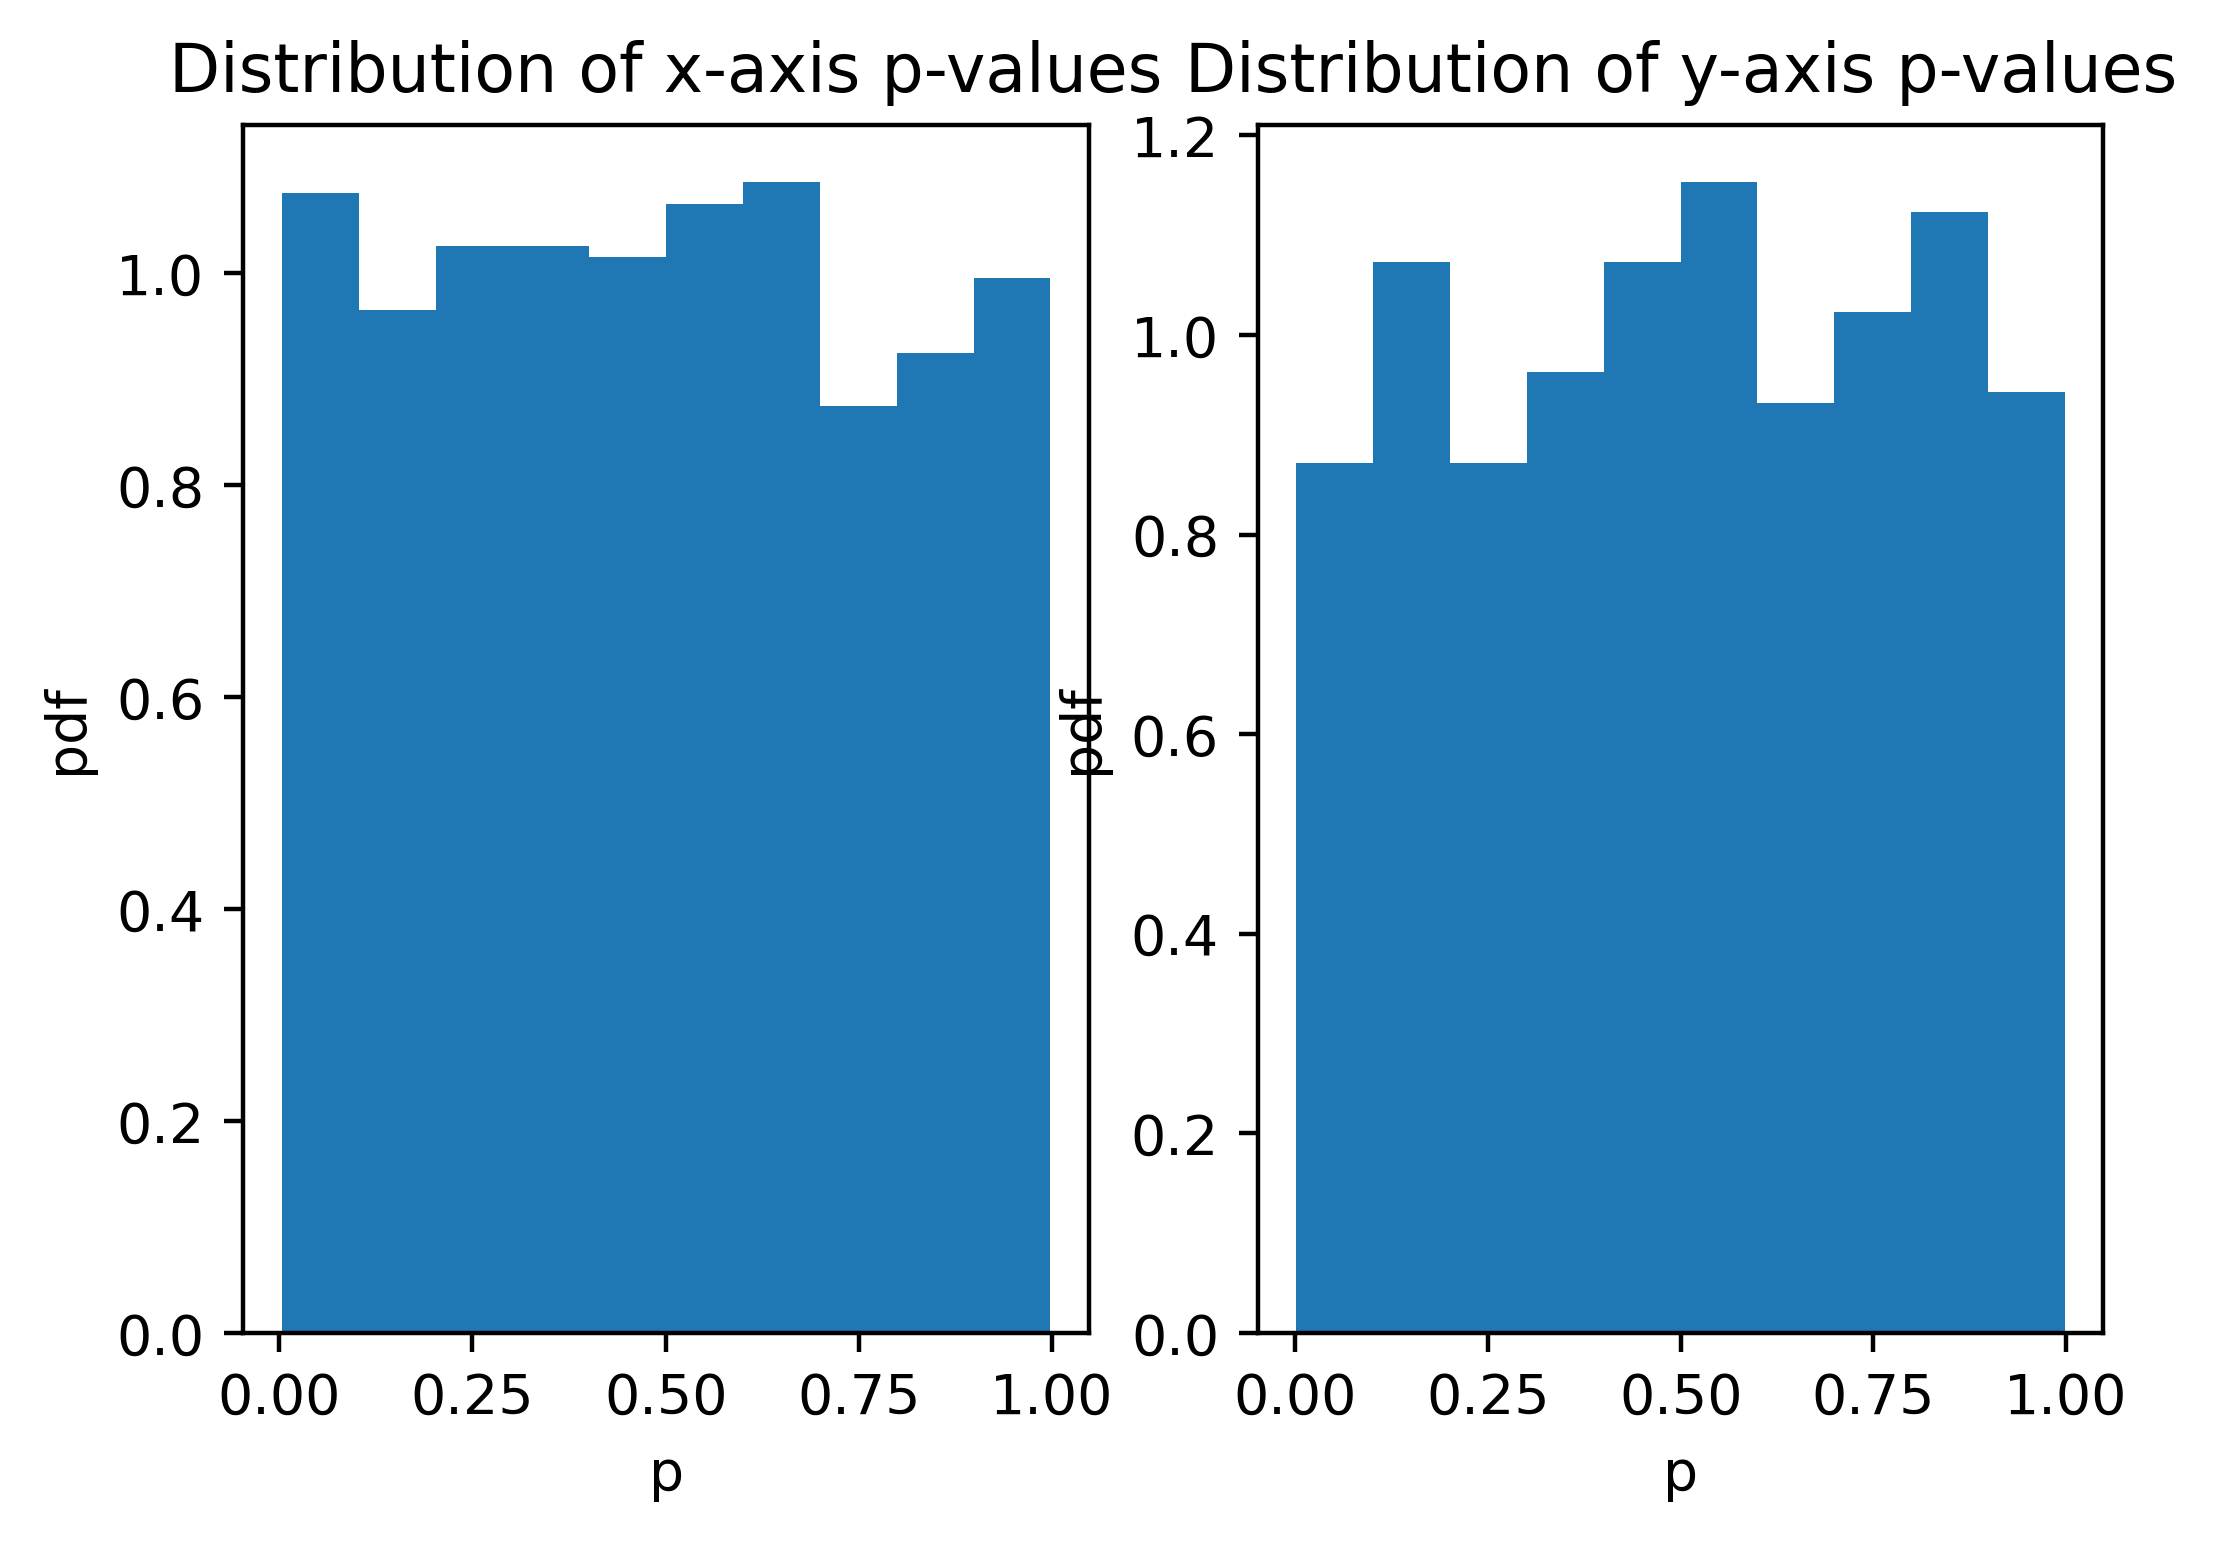

#### Dispersal Histograms:

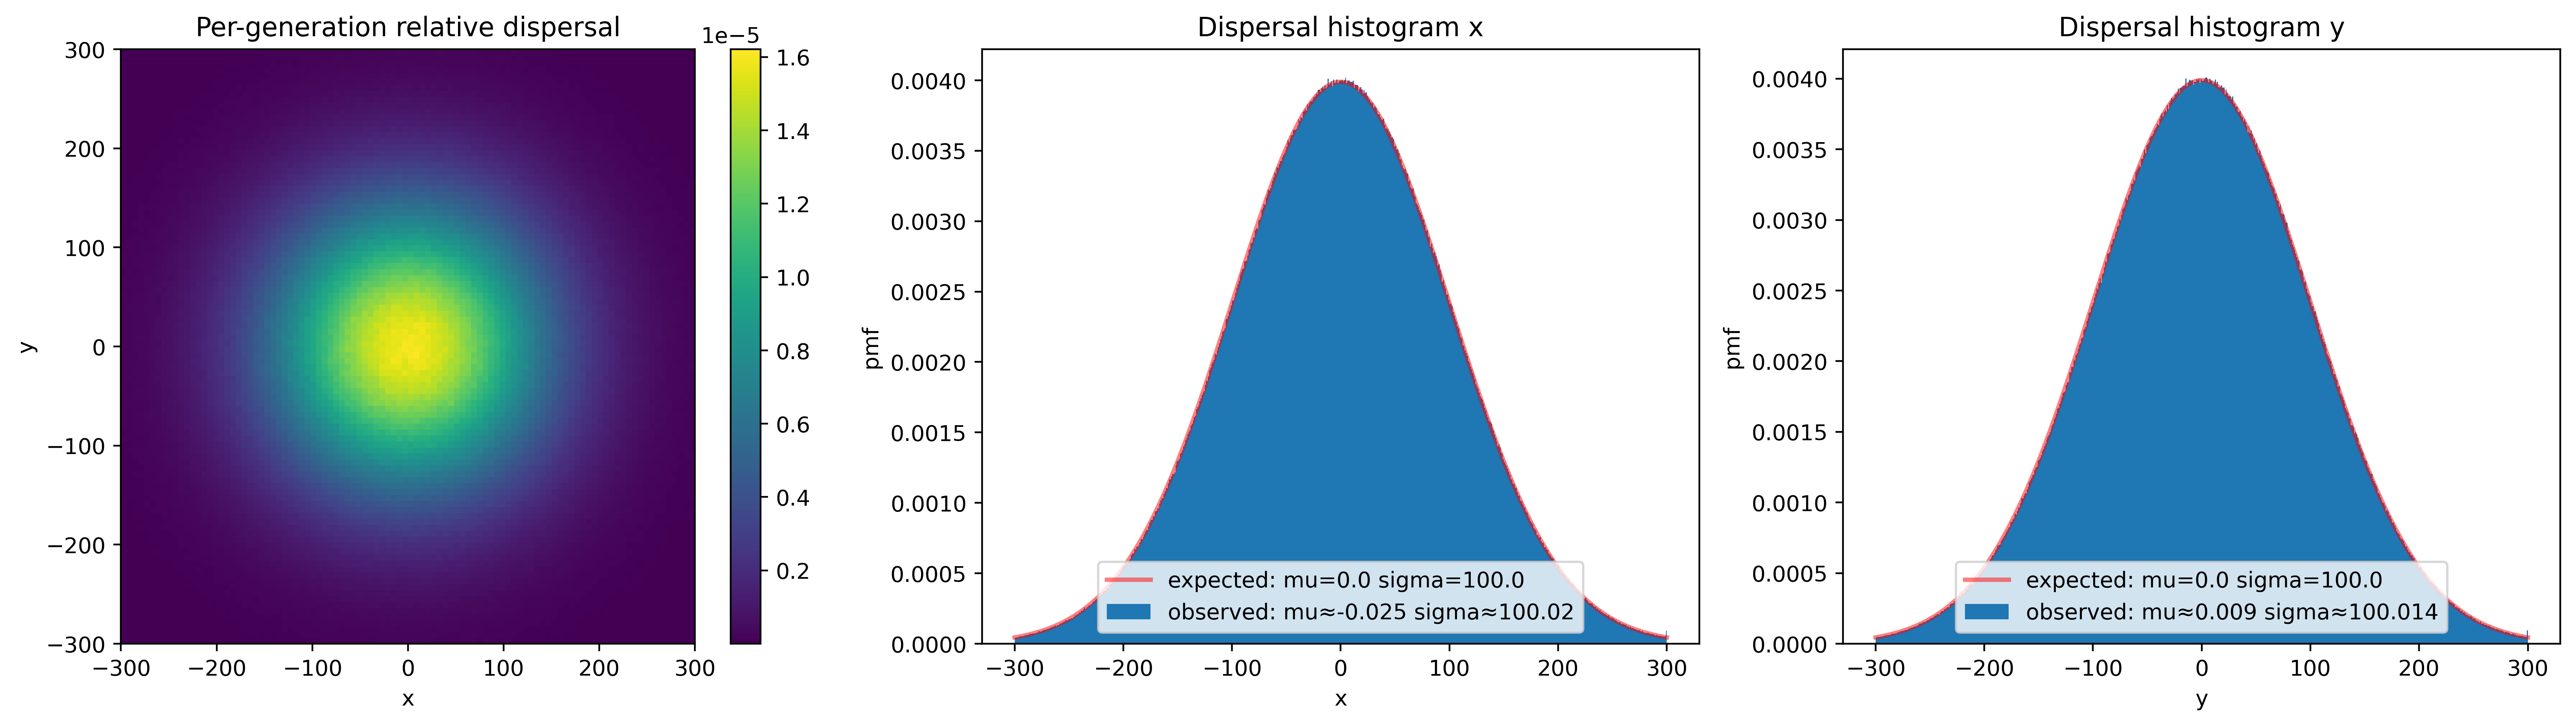

#### Parameters:
* seeds: [ 8298142281634393645  6781292252994680708  7342910797429455849
 17271780556799903168  6085357773126971289 17026399357423780960
 12330222630144472274  7662113826781836993  6095370419151423077
 16638224819117376670  3589723896762013029  1783859949442096317
 11837215636147579163  1407012757227780531  4488757595932245414
 14505456114335416187 15886267539337955167  2510731481182855873
  6554123777303992580  6064066083146865451  2085361017281834049
  1787435123051675403 10482893883206913631  4362475187304325387
  1241972523233036246 10015503102818308683 12983677735162210613
 11977310727598641580  1359131280340151973  3809676006838850291
 12642053629415040555 16687743909776291262  8960932085134155276
 12307525252889098319 11188541491984654997 17549180350783474884
   800969501739771361  8486956333436626468  9459829113833001540
  9539951773134061928  4487502440110388338 15397763293694401256
  8191158350011189163  5269775383683215443  9659163981824137564
 13085892969152821702  8942265787450346101  7312102677545390251
    10608700180621581 14650911789513496396 15566572587930489807
  2464299426361244663 11142330657119607179 15111281499384650757
  7405492642729333435 17204671252393174907 15348031924367964765
 12165836045299541771  3777026936605763407 15729457914256459339
  2110479435203634783 16472539821430419997 12821486242181307673
   445745879024136554 15592155537456544043  3396440521507078301
  4682701192032630633 13006114309400288648   586960151717212915
  6795091399551675887  6771811599131643326 10726008482957538977
 12187605973684416223  4027470740653787801  2817088918433260244
 18183396193041198297  8460289133197643896  1743361690290509051
  9752150390906395794  7659549847092407669 17493203458847990279
 13296933702668449389 14504419256792873358  7775149369350031163
 18380721255918962655 12498828901362812906 14966062594672476949
 17326470188206703822 11213098872037193584 12640924095428242843
  6263766660139133700  9167113799535393076   143022164561161312
   438530524015506554  4485739821684716048  6836151335801291725
  8267346928574182711  1043835783812874357  9805986520227677278
 14742638179474144358 10956470614793753761  6087733174999174967
   878441382108441185 18070395652878707048  2832748331324976338
 17314967776859063606 17709690950159313863  9415380718807936044
 15701463884576382958 14069539740492895480  6721801506528520557
  1755602316378934111 13054619831634613031  3929382487102262503
  2498928274037435883 10899048733232355086 11708264118483863631
  8850761611627173014  6301236269446558666 14156839405477497146
  3862844326313329649 12027788298565781002  3927337079376918834
   835441216802002795  4066279060864786433  8878225033339610060
 12889198551580889946  8696966309062130297 16178808779974811542
    96428903557778492  1387509200195133210  4824274759498527424
  3155413740191843015 12210560597311956015  9448711906891107871
  3991299871897131139 14072864294716127751  2314431886862667871
  8808344159074611220 16988578238380718857 12192530909489153981
   970835960613834400  8507091428369798308 18377100439778409626
  3670962687521094043 14555107510519075918  6487124815992592836
 18426373575422530673 14922559041578432623  1858113518114024827
  7665873163617305705 18072887218128800169  2491715890967029702
 12823596323577028635  1667494114918518403   285986375291815798
  5478850879442320660  5607522310523760063  1077077199101418182
  7156416263927517833  8109039408732269810  8667573858929609268
 13186275348289111840 12940875264457132380 16986326188084592797
 14731154571279728627 13799539350155169329 16499467469799180347
  4817265813414762530  8415791457785553045 10322836656526220053
  5129455906608714147 17021469682719552947 17778199973524074615
  5718585738825726100 13339148101690438130  2637411015071026552
 13309654321295681835  5129428588941062693  8567136916619079766
  3014693887064463128 12248405846929143273  1488929531321823684
  9237306202081490435  6834356782249523012 15452561596245897037
  8403371617999818562 16060921797313347673  3748771626477041971
 18191911823053034598 17863623043749123830  6411425788551181858
  7139312366736466934 15472001492091458242 10486125106080901729
 12456356420544839860  4345902832851089696  3707138290804281679
  5350056915731221035 14320728872559648757  4587001484005960111
 12221779386967987506 11146319647134696964 10192872005913401038
 12897052648131299664 15412370227699552622 16185020697749894689
  8230748963697445450 11773354877182655207 10210947626754602229
 15151370534105984947 13711995928214087914  3834635224073464644
 11387120115676914072 16312854413688917681 14605287179654479784
  7957660769137616470 14307493836293993838  8052456329273795200
 14043886022834864037   559036546089588215   289267430155653444
   948926739561338314 14690713239754712065   402539709782739464
  2543197153909341122 17534422139172395586  3762088791666111229
  5384325021062751201  6288836746902421998 16667604761869060336
  8411697122060507969 10143370927425161729 15716447077845904579
 13509355726713689527 16396856887984221436  5118664028446787673
  4020046243104778542  3933450454273547709 12545456299004297426
 17676574435622532487  6982546585843158907  8950880825070344901
  2918701141586358887 14218454373332301566  3498650788614808640
  5461826850433717546 16765680028359264448 14408773507809224091
 13482347486856583625 12445081121667702288 15317068333362160990
 10079795534888786075  9531463778411769761  3173554938653700784
 13009718399381524878  6934179486638493694 14399094958438934337
  8256847256785584886  3313662322859322220  3794698172189186730
  9607838022480722396 11081940177307958940  7162051675042052705
  2711983054304825116  7662235656217217383 15063406127692516277
 16109461397527394738 16701799755762449654 14173169617534296533
  7378754793973554345 18415239361147814110  9197426560667534992
  5561748834648248510 13335776846415901506 12068835139472184506
  6334002286060423793 14127188409702692605 11280596156755932189
  9651983074761130469 16549281193451120023 18354422395029218458
  1452379629129431072  9475540510252120084  3919163602631748079
  4083116735844580996 11078953321765825962  1271973072605133008
  5961969225909193957  6251655130406913367  2759831534691718979
 10098765634914720669 14943456094023430136   372833676243352780
 14819664913269168123  2256661868093986989 10325114282082302660
  2114798033993450581 10686841266793213868  9881724684252804624
  8503465566334810083  5299984458235668891   831455540120177283
  8696228076938909649 13042809311659681529  8809046630778522672
  8905087584382332007 15998074227393036968  9864873626941251345
  2009451608631841742 13404857005071325275 14843130877373360750
 16059243729671390538  1263472487123956934  8519654663551189323
 18107732214318378633  7263932794914795852  2564793564185718812
  2658551728102006452 16842406404949534099  6364921450289835674
 11471359792954070848  4601002758516711385  1904084192821654327
 14145263855816712477 15285550187685291742 17789748409226470812
  4597888251813024819  5276141910891336651 14140986965216343342
 14631755360274111015 10137780060571235460   820146806249612518
  8028778640409655383  2549059504779597830  2301198422141617049
 17324928727714204644  5659819303279202282  8319753440023881092
  8336816078497540849  8467041935405832019  7831511392921141422
  4241926274884418420  1802090005180074443  2053691671306136209
  4781357456215388655 12471900881464148547  7196681457074338409
 12451124852293546107  2466221327016775004  2600355215130060829
 16955631417802553473  8973002720691092146  7635934541525215117
   352419063568270250  2177891981140604571  6591243228062234805
  6209880941419317033  8669941619664158936  1145049055317434816
 16423057862983723406 12934926621044751925 11013750523635310643
  6600263911999080533  2207787976175645643 15797982053340280183
 14160884982307160334  6577834775977452606  6406338474078286245
  1095169996856401127 11964224196960921609 12928862693542721389
  7605228807737425630  6649973878891317101   457150282300113539
 11422600037052187148  8207443373502528477  7828243086456818067
  8331541284706302773 15503592876341060008  6530417967202235533
  5892831441599066364 10264435568526805208  5992404655964187607
 13743192983587328456 14971160692715750246  1379891605386753544
 14262263285046100929  5755751206397754406   732617977816393899
 17906788608494134491  5279231599185103855  2902544135389232459
 13540175670894340323  2306931232523761951  5628527817469333598
 14439163648684515683 11087492047789343147  6229467187407211664
  1527920204259329371  9044033063769394817 11823416397840569697
 13539379791213652046  7732752328118539858 11606073955049540965
 10465591774736926820 16244769301545272148  4504780633442141504
 18086855319741229141  1283677422600053272 18313432487555340682
  4257119256508524815  6680245130826085410 11891821246248722373
 10757385180088651377 15363949860563977306  8451446669250921914
 15634423900332838464 17828309938776239765 16845649487447884853
   660007236740948859  8979570825171878605 11992313306549781288
 17946709296183247372 17978917689791864460  8956796622769099475
  2581480377689813431 14662193993270300471 13845250313700016946
 13783915204583057569 14349796219062595754  5632670433994633098
  3901346762966804828  2706582829139984434  2449085876900586601
  3087467594479529189 11622588540177051936  9450219097297603374
 18258003481132279091 12487331160573630153 11961943608983354044
 16298137423381061656  6071972801016272465  3870087634869175370
 13629557262957005518  3263641286032116451  6537531087400111221
  9799710269426898129  7943210056873103991 10180548139969722737
 16988862170002411535  4740347364787298873 18002543959289001570
   342518819618562556   933438956131497870 15171540046927167346
  1182091775764870525   657033971405025846  4453681569191312801
   949486919863995076 12668232703903274835 13422625021632880333
  6149238954027808780 16777623445195476839  6017567479671108943
  6822400039150715695  1287149389058666605 10446545858415450298
 15665933176281521265 16816704910661701544 18328154583729413263
 17707589400987529175  1274958450570608469 10735695572108633121
 11521094584225114437 14632718291432105704  4929477119569498935
  2570001376371116391  4388394991802322088 16169630618248031502
  2886923194163748040  2515416195653966383  8620455990411870018
 10558956789754298814 12128315060447653573  4885904554829481588
 15986959613402957033  1356008344845027103 11298060665661530286
 17042619096602740555 16049196036164428220 14515910435573375578
  4451759522105960146  2992093812356067316  1320387576145051765
  9461286034290755511  9824704154250753197  6560739951233142726
  7853542241017715458  1298696007257977233  9692041447946188136
   743486702211636564 14279601208227047540  1140183112328133177
  5580979301333956456 13458940035210980924  6012191499203890902
 18399272525885083841  6150766601646539740 11433896618794329805
 12004485809391079263 11302712938193240333  6698717066892989423
  1153164146848625063 12358950573427198684 10945390785856258612
   503903346999140453 15207429541675026447 17262333449255316809
   721738738912924662  4762127458186968380 16800275679875090861
 15942548613869650553 12326734951178603026 11179841233829100080
 13216958827401556022  6634523527903938491  8507844679794744501
 10558577785784216439  6390937968974299946  9812737138942217693
  2492343125055151484 13592051827761753409 15513845979865445585
 15579166069365707193  1265348552710254152  7269513669721905707
  1801374185967091182  7718606270161425194 14560053571020957070
  5663720921551318447 17250342167603577286 14321351719960157639
  1660211473136605419  8465949970742251291   765224967260773461
  9361440773602417548  3109798640269161304  1009859668009519721
 11265776938603131481  4868375216483574025 16884935066080954536
  7605657919456419738 17170460234834845982  6722058421685029201
 10395514938960748953  7908979826164395195 13791944186101036864
  3684910257139577945 16938438177967693836 17962916666509649049
 13601773019253259328  9839650159478801368 18166413405324716261
  1655480282585070084  6213822477957492200  5549666983761934250
 11026514740239481630  6212661153430587349   298505233246281618
  1691496809138935721  1120062474568743590 17424093755376171082
  2903231625622960199   313266602950903444 14708721081761312032
  4262542601409936906 10241584471760348326  4108743745365789485
  4445712058276043198 15979275598489889448  9435857095494292103
 15030448064302391378   713448582826608562 13116568083737850088
 12591209546948826587 13583342990325037774   732204619231560696
 10046329625010569353  3189122131704936897  7303596362359031947
   232377983487721385 13678952136253106858  7936303587763701069
  4931881196829664003   914866566022055693  2482969698766398067
 11110720542136213987  2340699254273839842 10807346219508966544
  9654296143400957676 13697958077619955281 10136296469397092695
 16420403270587493266   684906099899569329 17514650441176662589
  9032838641345109960 10206054229457810799 15604743025400959528
 13686988214240406257  4167717357892406299  2563608657920919390
 16908228992294919451 11304522283794552958 17293123786862856940
  3363008918351959296  7599816876852640937  8843332882710374238
  5844663765087331553 17169371838401820883  6107179313780473629
   133249357239622390  1532435203143789734   638564690383971806
  3489163337848100210  7461577113850675623 14117055916277434244
  8017600136883588639 12436925787817315101 10776672199766956335
  1030778393217262507 18224966634913112534 17029207660290988818
 11221580093659701140 13939394718234574166 12046631352559981358
  1240642160336022552  5846868864845025765  7334436990081267317
 16995675799953645550 16650957769001406953 10603305963153189969
 16587964892527482706  7270112332571064781  5856679013305901474
 14533266438992135067  1406270459849003182  4917608866592394413
  2523806715445856346  4979976228203250271 13235509766677277697
  5478970959699154998  8458340165085201360 11086832686878690437
 15802540327596707227 12814111632129939007 16976064325930100005
 13751253321858778568  7459246304305806681   899490790580310576
 10988907153551760959  2638459657303339155  6562408461682512007
 10916617553786174078 16323875376820762193 12317350747706595189
  5198662300591245350 14154273195394147462 17794671079965110065
 12487294873603459538 10339218558402401893 11912654345485728964
 15337966264730388709   611650630182945466 11167000387792485115
  9888955567359763493  5878648340096734875  1810310033736554638
 10669703119939119294  7304923236771121887  6094274832458282093
 15283244809255379743  8223814541084208270  2114035077039015435
  3773736743416388874  1488053598711315926  4442642797986596580
  9437942239453360266 12684601625307854541  9390037293435037182
 11484559258779928863 15723489852542243317  2200161098292021476
  4306449549789402807   231716297019464284 18283560286857986286
  8024738679520467670 11034874529266907953 12819604326213579966
 14187987108680701788 13869676140030449637  3923609737468576881
  5624546544885333288  8491827514148413440 10780861145035158548
 11368736593323543700  1546148339244705504  1909632085731149638
  3483433195200541904 11736788614424074511 14339111740585344752
    66628616271970196  1841791459687223388 16011160244433789809
  7423850535172617702   403689041059117767 14486233953190964210
  7139517142400259476  6436916688211548477   745621101247647015
  5189001336494485501  8375226229461993339 14034744892116648213
  5526027476058693791  6150172628114451336 14642654862015238210
 10973642243250965115  6031663537818584205 16980417188949212670
  7521542866990680599  6975278298117505273  5936726212762837957
 12241212741107358420  4319763039139235650 11057045726304788201
 16966906799690002824  7171242865829541552 15590819032131348289
 13997486790723436589  5480840277693472754  1146030459279976454
 16335071273558906436 16655328924062175511  2121900412468375043
  8665632822099402376  8811833356187422537 14029504113948505942
  3886026045253974873 13908856913551614635  8062526712435978776
  9108741356372839691  3422480164418549234  1122676141046641220
   198527561717321987  3582526363152976570  6264628441230622678
  3003215827176043877 18422438632401887257  1024423649873616719
  9207387729297917840  1294594627491527343  5094306642018040751
 14773914024459707300 16361860539585135458  4295879133509557932
 18230670979753250239  3006779007140758011   767066752525333229
  9847486181282080696  7741390558366426313 13316820300866469647
  1601518905138252944  6163565650544557894  9161814744870502332
 15767434562765725575 13990164875007071525  9819030126350222524
 10366662325723869817 14839788676597365702  4835395433837534523
 18366623186434480887  3734155499739165401  3281956886237065959
 11945837791347930626  9530959619042151609  9127918876650984996
 14827608027671125200  5785653123088541864 12406589215322245252
  5072009563489004811  9345792057268842779  8617487386177233334
 10450731685601114028 17270986135428991297  5122623702928508122
 14159433087025269605  1128991522870439231  4153903883244574348
  3428517454288883027  7237925243567049070  5426984789510620916
  8357483953767797075  7444621417250685855  1124579928559363681
  8906856635276041731 17271275600321757047 16514098120462856415
  7902691833708211517 16715496190737939442 11066480187061501029
  5007250465239262404 15535554843687425301  1169080658725884979
  2967973369548261840  8373311898629198347 13844784365027761727
 17533173026840243789  1891681628920003599  5572336194460784609
   160340299262989287  7890151895929305003  4778901572774159401
 13400578172772418844  9433195119693768835 18324691633556144280
  6468688946653077112   196900178410823358  9614156014955251831
  4865629457651332414  6907621050777547190 10992504499730899796
 14118402753636016270  5676941241273165857 11673396698773552719
  6573424444277299733 16699968092612274948  5195351642595721278
  6344825448824396299 13755238720582504606 18399812691829791160
  9718273095515807156   831813178480810966  5139208885635950128
  2249395987137145113 10683544629662119599 13828656701706360939
  2112147666230974084 10423562496046378351 17457646497052670132
  4318849700581788920  1884826923968285141 16576835207345514116
  9548734881284340069 12612009195185850830 12113422810339809756
   235642524006780300  7378597138322822258  6419292262209678960
  7488145556019970553  8696886394400309068 18386740753319954987
  7389639258679239327  5914729818374451634 16839280887658183897
  1027772328759360873  5759153778744946683  9155815744512791421
 18117856808953078590 13783405719864558850 14450527936170162968
  7675268451425760265  1703779739583410256  2681431100842963542
 11931039655900179399 17143790614703054044 17818991096160490115
  3390237059563818398 17569607062120733091  1685846322436615731
  6201970619175906640 14796354886848071547 12671296085838320889
 12625361057447877735  6958539802491913870  5572801059878390376
  6092924821980284951 13974805212819833104  4608290108539883010
 16113713933352053205  6905198536157261249 14495779197737487636
 10252291571574254348  5383054320816524706  5727794181045146374
  2157199394832272732 11364603246664924598  9519792584366499843
   491657591792315402 15697117959497691056 12485839167619181698
 16812790536709008884 16776831731006939995 14370368914655372598
 16486952042808859677  5859539380929382291 10163287841274306865
  8164521527734792921  6172754786186357628 18039519421863854591
 13616834395872456176 15297982718152239925 15392029872667279445
 14590194146069146376  8005018311578997724 10880578678822100656
  2452594860340549959 11985181610375154223  1874544514460719003
  6183425454242588832 15810849896685375252 11896307363556896332
  9753601215863637326  8389503062399264047  2028818446442003811
 16708338254558882606 15831914122042007699  6902810055470618348
 13463415537428302154  4794145544039279645 10575296867010380871
  8328813487975438079 15282291341053028529 12951955428664318303
   523873509846764511 17370950888562283798  4915423342368522313
    91237689580631729 17995876707931914835 16382237982997284731
  6454824710791128534  4354229246083204135  3381364405891120178
 18235302946634503467 14191619427524054887 14532132116389335436
   696037682949149026 17911992033790195330  6313917714813428169
  2859786528375185444 13122581380579328794  9660759010633496006
  9239373537774944582  3057988769746643751  9653592457114581615
 15443765497324229716   704391636634282157 13024682926317498479
  6256966052434281296  7511562801653476363  2603161741912588072
   961130357498322115 15119411849252088379  6246840758727729158
 14709979920040805693  5160290881596893792 17380877160772454579
 13755036600388138248  3476595532713427112 10243002745168502817
 15622434033518194274  7329462598289675950 18407049531324504594
  4148390143055194703 14497538529911068360 12869217942849043523
  9982610358012456443 17275162479960041232  4798953339951231581
 14314320396328104130  9506115159120709154  9434499155164594852
  8297678400098400160  1072751649253817326 13706617164614969544
 11438426068278127448  8886121165762236913   938030033740968185
  2012117710757965169  9446668562872712847 10278209392165654801
  3228024593327616452  5328250009534435491 13876401680833053342
  8472506465771259086  5573940551666821796 15540456588681341916
  9267646544583612912 12432903994928687155 11795309502122603429
  4516905107416309665]

#### Configuration:
```rust
(speciation:0.01,seed:4516905107416309665,sample:0.1,algorithm:Classical(),scenario:AlmostInfinite(radius:25,sigma:100.0),reporters:[Plugin(library:"/home/ml5717/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalCoverage(output:"/dev/fd/2")])])
```

## <span style='color:green'>Gillespie</span>

#### Fisher’s combined Chi-squared test:

* x-axis p-value: 0.4414729629082249
* x-axis statistic: 2008.6580274509918

* y-axis p-value: 0.4260305995980745
* y-axis statistic: 2011.1488840248364

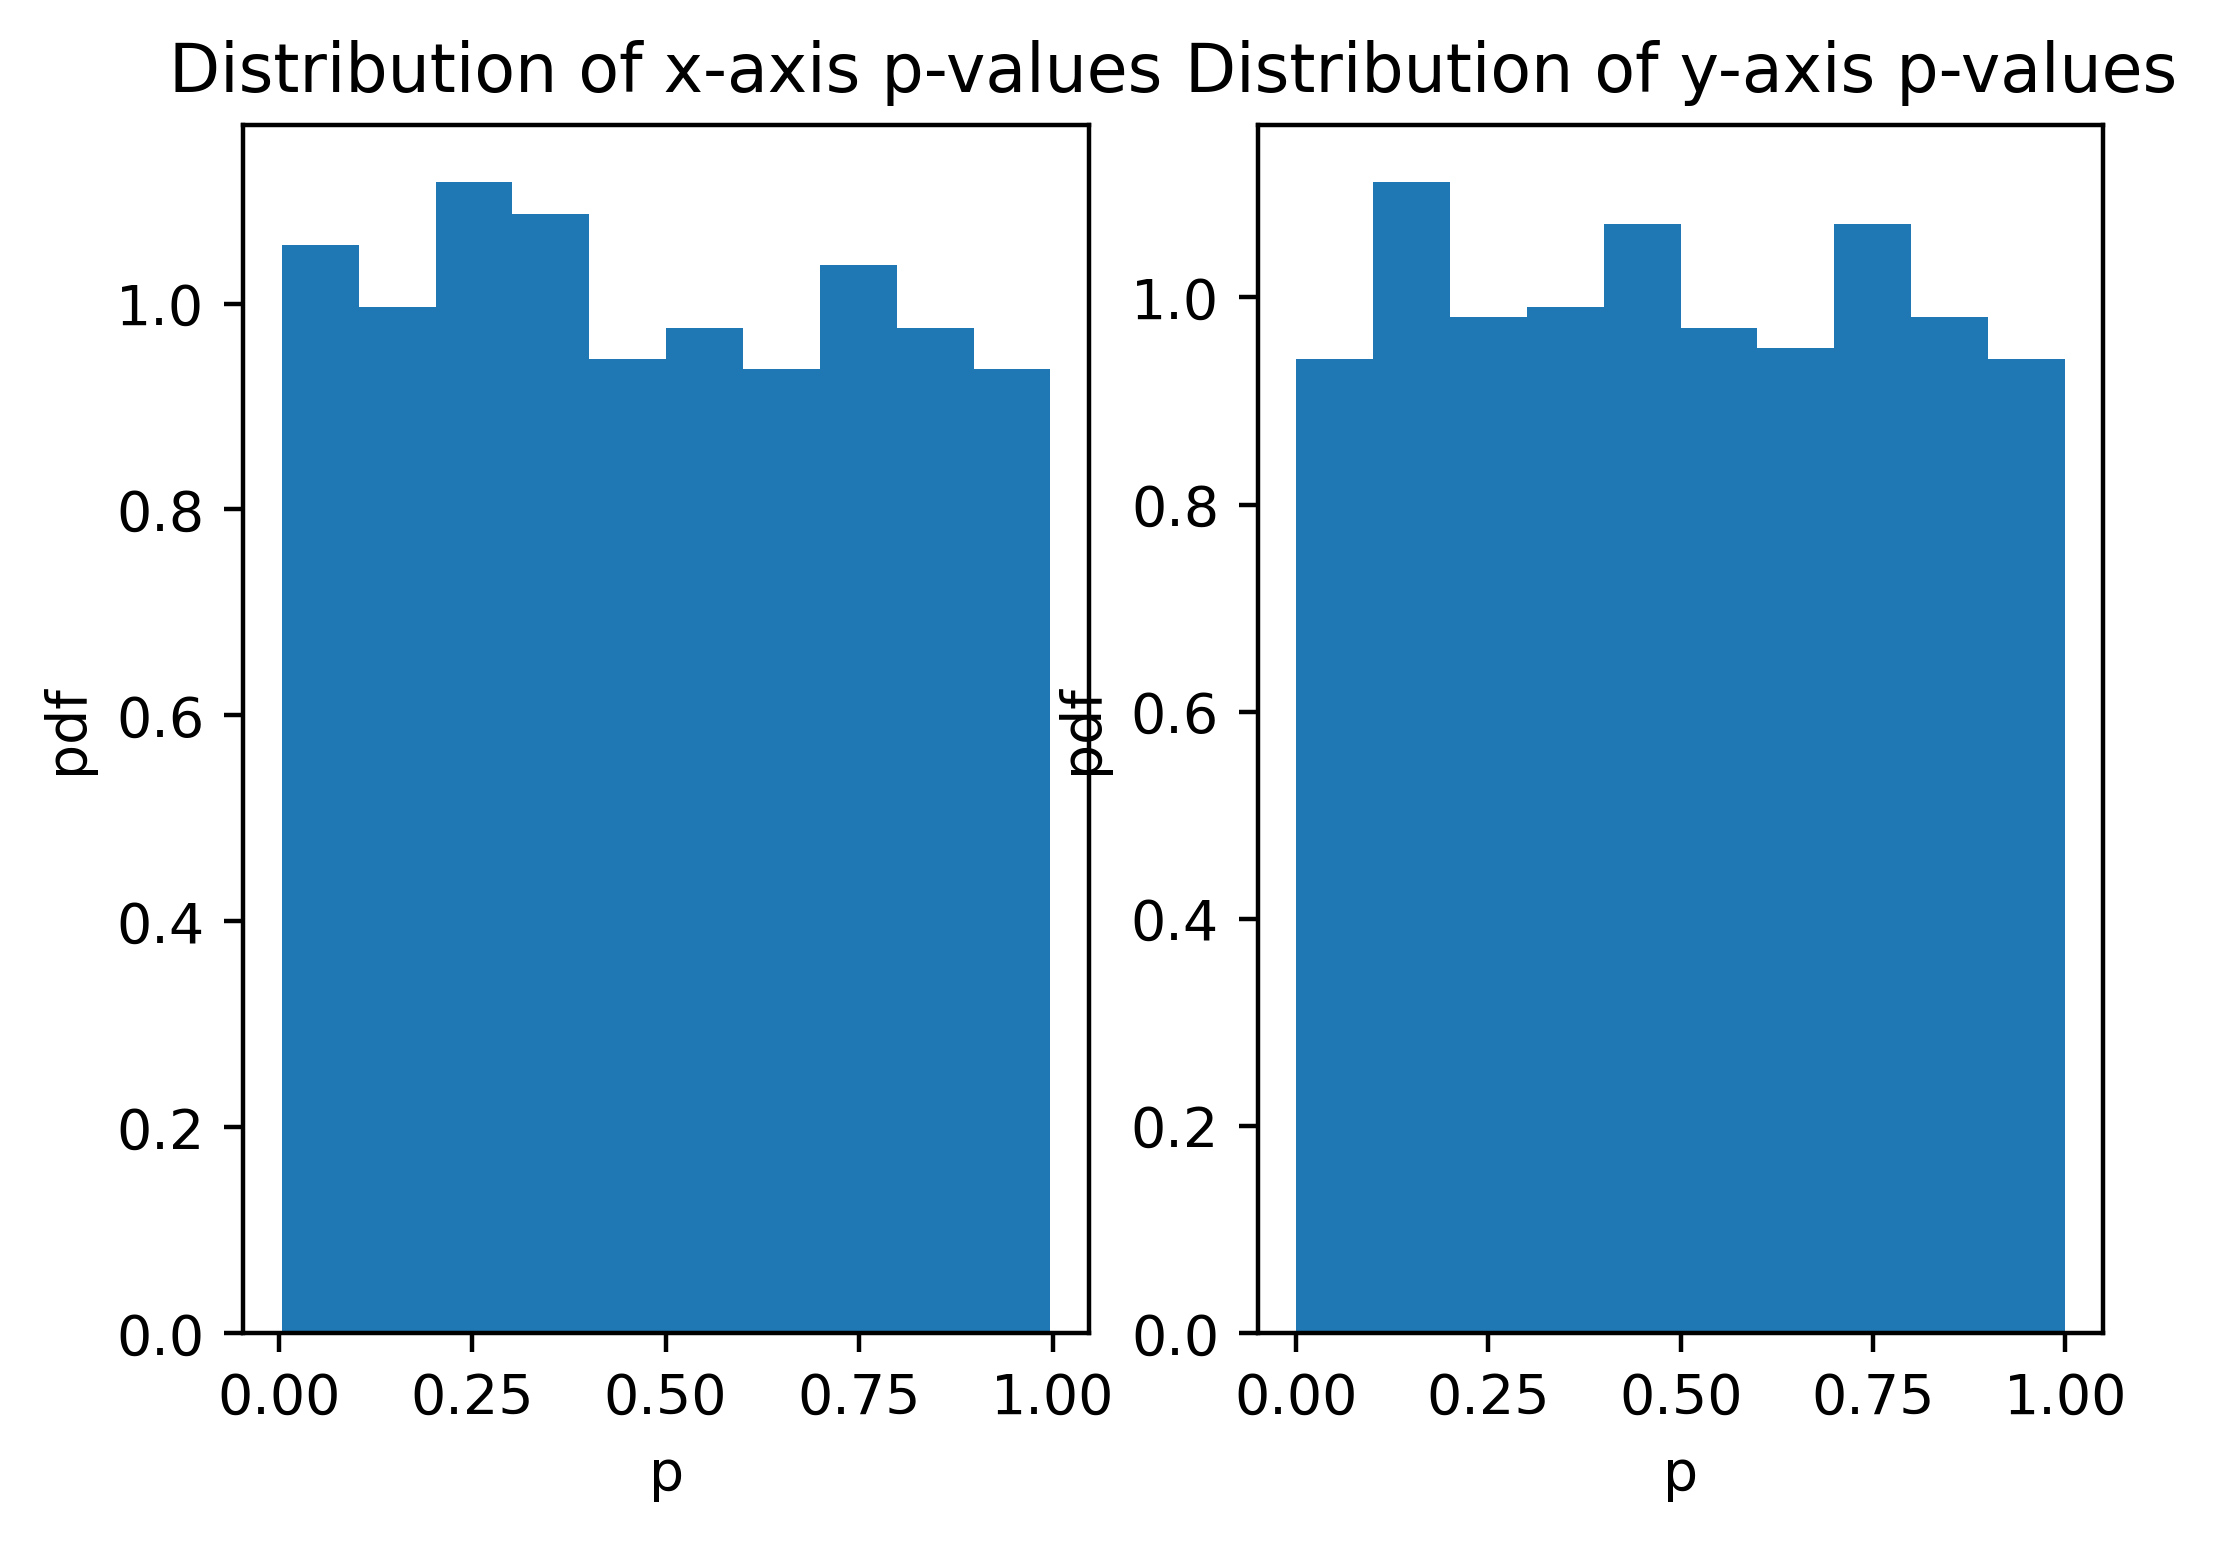

#### Dispersal Histograms:

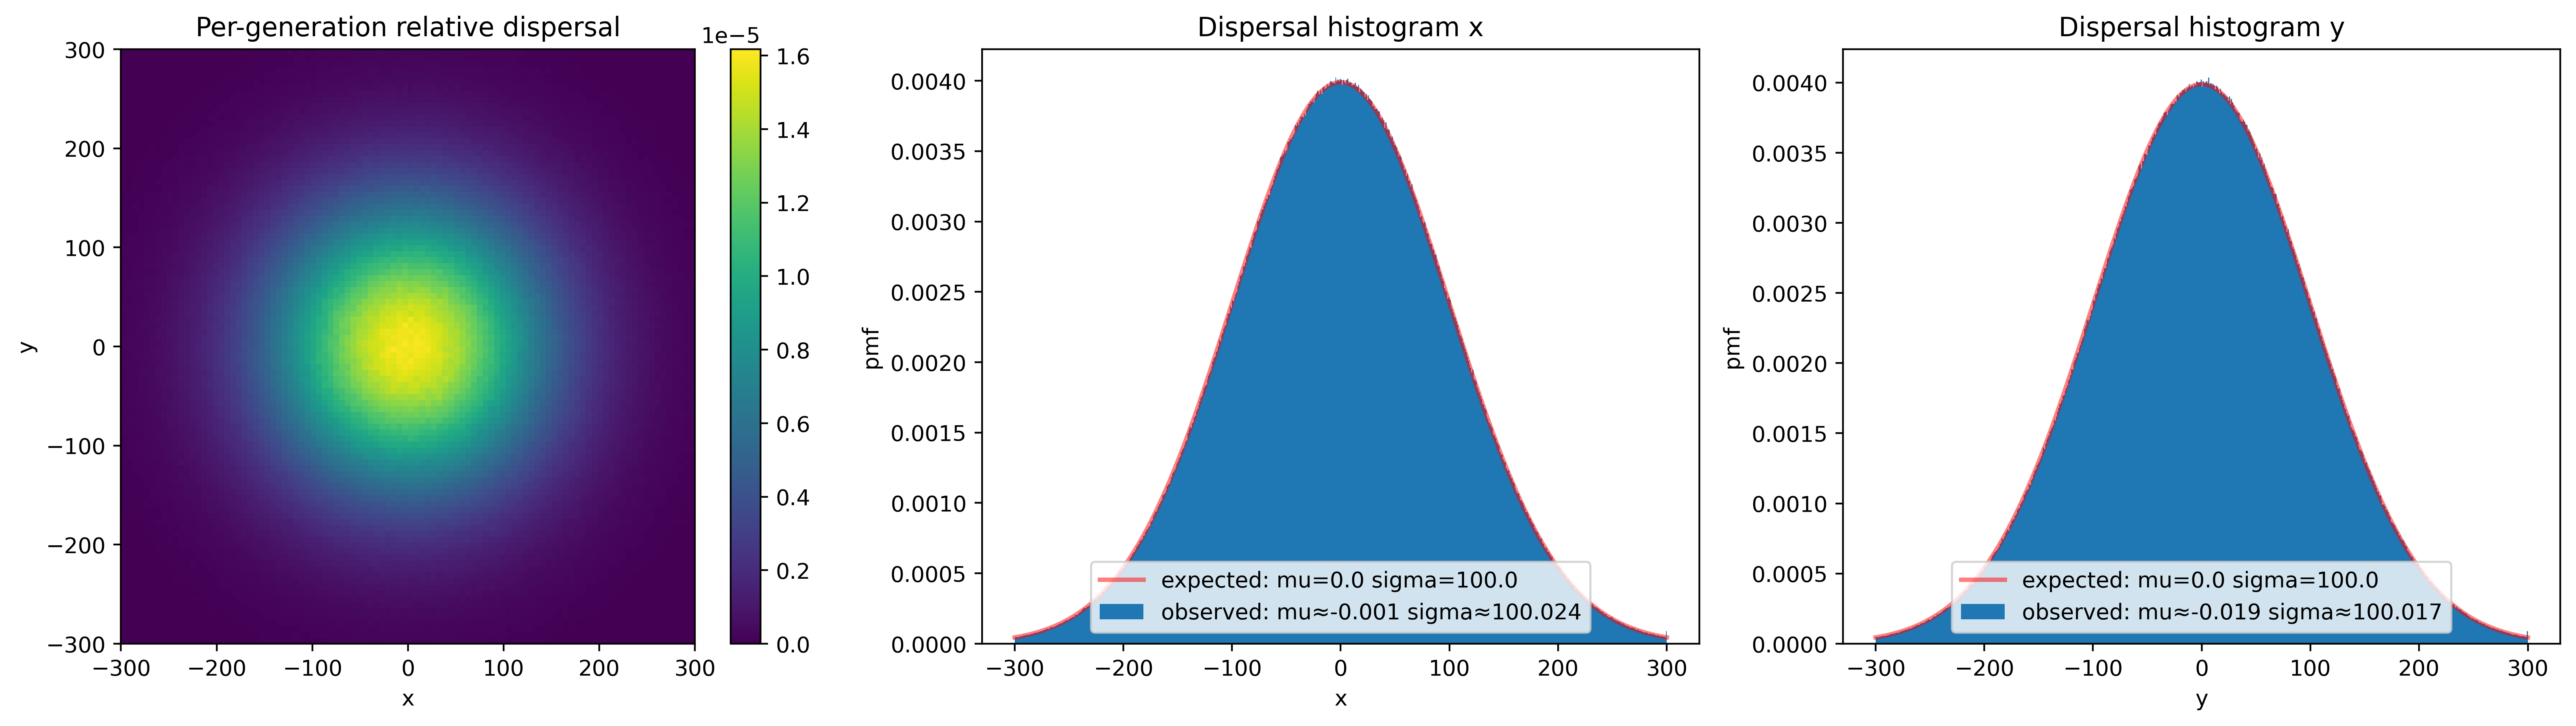

#### Parameters:
* seeds: [ 1416917816262216724   125080567820116945  4121082882034280501
 16463353941231375355  7217611621725508368 12337228837065179976
   333212270272891988  6557051785395380681 13005410864666476249
  1976812397204224887  9221797191874350018  1315082510488041259
  9338977414426310004  8985005729750713778 12552025123540085205
 16849498630875186991 11061768774514741511  4639035712314465301
 17151237152918698254 18237040150352571989  1350025912693685855
 11232949265593152742  1815587509010176949  6993327652818162136
  5628060671450279106 16436752857968394912 12221398400038622066
   659949933082023940  5444355204751658046 10549655381894873845
  7504967547623769035 15566478091962294475 13565836930866933598
  4508002227906524951 13579048329286272717  4237696331087974791
 18367018242779700804 18059955926309627821 14440615349159972988
   255326419839771596   873253444941057463   254134125333818212
 11126396960025404499 10741757438207515532 12937743390037490467
 18114967433341385434   207762796116325561 16836131094606234736
 18147490691174213524 16883915164244206606  9287641321744895180
  8231317603072685489    21810852174838129 13360522634676970553
 10560525603166463169  6204614872044410154  5674604573717008572
  3196679099017417724 11434158451734104967 13181492171601956081
  4286699049243480516  7568478075564712781 16345261784470407828
  2074209632339309068  9158552678497383387 10536882498086223997
 14595201738965305060 10641377411898302584  6227567287835894475
  1749791361023316839 13956362374494234566  5378011485729602027
  5087805783387969258  2829993184840809228  5838079611373949643
  6359167600362805849 12896812785514827565 17643171984024360151
  2167011071370243436 15987233253032645273  4417252620679101226
  7113469125351616944  4529909624076010334 13023092678964631230
  2565524427059216279 15189339647955060338 11443562332903254326
  2672253169181986847 12736941389090261757  1964666390928521060
  4094743764430733668 15409316977129774602 16751710195474990568
  7845140188431037411 15635704277459256741  2356077914344422218
  1330045282318564542  5534735701557126391  6653203912431340928
 11052020962715630260  2139881353940158654 10977273455289948846
  7622382558575707426  3678469717046822194  9783214695602109168
  2884425152420024323  5771488785578810691  3206804975080649859
 17199851650351726936  1780111995141667965  2047941640873893814
 14807350648108242948  2093472238158206212  8148856613037834181
  7931827781680222744 12250448820823385616  8010408469159297495
  2779600491169558621 12196360223157309481   559471550131453927
   773475039149433426  4331380781364138647  1211450305971554097
 10570652520673044912  1711139771516964537 12173891544731142209
  6359099795412658380 13744392642261959594  3408467838375768797
 13391988426485838462     4513851560831189  7800298126243663715
  2485622365235618455  4806900248669487924 13891319880971438312
 16878254774532130917 15759094882920040545  5569006116390150795
 17059938759078053443   436745836064213301  9958681311914529254
  5849111580854809502  6082615268954914579 11423366132953688167
  3909991084245854523 18346338616291554417 14170569431622671367
  9537651601291194977  6878257209667776694 17967282386536206235
  6287624254791738203  4769641904764201293  2705535982987391370
  8284748198867271150 10789506493582434057 17079738664591813391
 16198690348789090701  1292796106289126858 15917062310074090154
 13252742979364186892  1289108888116008539 12508094567128560497
  7548720761190611724 16733122965073803990 17204032995515117804
  3369158313061714987  9038767401574937335  8304812655940893714
 14371633105695150428  7398736752424574117  3177958128597665841
 11687884111651803219  8038452183540342264 14561638096741315579
  6690622753930344861 13881100841120081323  8807664121238339807
 17724351507704421569  3539526230350512960  3958719235354473067
 12347326761730793143  1298857141158171685  6982642906176066564
 16464501947083576374 13072624006406059145  9738219801622965554
 16136239544605986751  7471009594293476187   224468250024252624
  4899609156088669986 11967983112467574992 13313908354752716545
  4843274936644460128   171019276999351747  4005257653583782396
 17458222237974583310 11074943136951028471  7720400077888743996
 10192299286037511988  8283637788325243127  4240259118243695418
  3856787936584064223  2660766275548934024  2597231256747381423
 13921011160671722880 16709933806927471921 10746061772589065202
  7367784560719768609 14105097906790991411 10319475584616664786
 15306672380180722277 17167262030006440595 13103478287063426397
 18039682151911066718 12151601176085945081 16648575832652292302
  3712715959095694608  6178114905224141165  3712019902189766334
 17139554492921198431 16756560664372253766  4126813947301540097
 12089090675737864201  1296913326547107454 13216637937545485443
   277009692805876267  2651210849886868135  4247292635711954848
  8843320723299591524 14847933683817709197 17970940524711529654
 15547536506312302514 13030136626452561986  8576738441067871233
  2018220140331663941  1933631304557533451 10326404206392472099
   865958710702239469  7802319841004158452  5867243081570288913
 17096977072013992987  7696689501395361039 18357600705259225827
 10271192456259086012  6444997239227402847  3409028221844179735
 15724693322669610041  6890073142882084321 15150892228720115188
 10766420297214665050  1795469094764552566  3710221377276530506
  9608175928015910822  3069840641233329800  1307328654922401569
  4993963688312444971  8621736222463010086  4495202880213250200
 14007797683207866443 11564938313201048951  8417922562491985622
 15092033334668146364  2988532959481334987 18031319575133561534
  8093633321689159170 14978411611451959349 14604434498153820944
  6466604601695865595  9601707599314866272  9320457327144899987
   911410702778497292 16227900155112855287 15762617581011426970
  6022508622224549504    87267884923028346 11298651429850506909
 12785985808469709589 15378519785911966572  9477214276419734302
  1359001513933449101  5803070637253742817  9519122655189798279
  9626146861355151506 14925312240239135938  9393564445551912460
  6498044575079114777 17510270760087743502 11849198075606114890
 16171953370702819834  1718881377603876553  1565169712539019552
 10334245029513064705  7128377180180555292 16146685888244557471
  7049998923921835753 13310792698142255695 13468054520409191318
   585051967615600740  5206271506667786197 11016577789163689005
 15599192323844937949  6637629025016128931 14868689550882870705
  3734629939257809346 10953040304279692430  6676709744045822910
  6335439775165994453 10550547520156680616  1964398044018109767
  3363614321058175355  7438298951105759038  6682040165385633257
  4241799488449502711  5686233830807807008 14603312743774478447
 15704053048560642239 16095300989301251782  7342694756963969507
 15625275277374688550  9517864229516758525  4446799752853920413
  5968478291614737226  1748476452809196783  8453947218608281272
 14842640466577572164 14342935058355545342  5715657797091188669
 15843395242371692123 11641516566640865955  3782010558752447603
  1378392228451428403 14919160404779005270 18120158593811691097
  3228315545435574687 16505931484529956029  9332280047598546138
 16112075677184222169 11159222271060556035 11203412883043819023
  8854307793494936230 16592068802442681563  4642710334790194595
 18099446673197788839  1619042965518562941   352048266706199709
 14485796977478483329 16151751986668770363 13795432222684050490
 12336285631332651917 16994208240334918436 15543799320300098356
 14672488221003524964  8890123696056977788 10738818357155753570
  7344772379925297946   971850832308404615 15533218062532803222
 16907453928586496104  5109696963888632744 13169440868121328223
  2428043488424100860  8180823231919765068 13198137011003299783
  6625147340279137219 17774823211473400020  6334314399155796874
  7305708224217917134 13994846931928290338 11771827588592969999
  6271666696591054753 10764265091143241469  4249940064470424557
 11565091095715674168  9178961812713802954 13816575521555657321
  5116446920514034329  5735879225349594961 16919240862292317956
  8187025094222074470  8948231221093465036  7662347666055097525
  5471136736203980293 14796830575410252040   664191186988189285
 10618352302322274058 12951380498572021394 14583346920574464924
 17252652679146470752 10054610133216170844   653978668223847951
 16303724789592719172 17705486770307891301  2558062893491620315
  1821018183770683106 17387504125681604243 17812306304411993491
  7437358913912278965  5563745005499990682 10196543449043292467
  4417707581433356673 13695703443098542731  6955243727928902556
  4883269955662211059  9170479740226825587  8708172073252848107
  8425421463470697652  4000156223996133176  5590818209826694049
  5282025386895128227  1434338458227676684  4682887480333511952
  9597805045217750335  4490908238249777644  5168629253607553370
 14149307421876470012  1375270514349526384  6982928076819750614
   241010148009063497 15574094153075684140  9601130746830257996
 14617207140246148170  8952865507029590679 12030457159074802204
 18021841480472385882 11446704558478291493 17276566704474676957
 14910744975905101062 14019834295551049178 16916454044405286694
  1511880767807379766 13709901124291275649 10505736734766883110
 17938899653683449268  5055875108674451556 10768265447658152386
  3701164531152315422 11714953774035570160  8956785801509610404
 12810536487508100807 17064888956893223345 12955783437723497552
  7938273389185497271 10430742181784027612  2528687212280920200
  6811786140535525454 14574998541410056886 17674302070982061071
  4565982936320146425 12421021814591014600  5625848960923404873
 12313660419252894251  6814401736521931469  3753343133717085042
  6538241289912410200 12088201625002945314  4247371456203658127
  3534086081138026283  3708642853526129025  8774575063097499374
 10965896430021590401  6119604634335425781  2294505474634401358
  9919483707515477507  5788227221540693804 13048525443667754667
  9516257159820444201 12615732874712212274 16971120882033233863
  2001333009881059346  6793149159917847892 11786730451850351654
 14739096815560416872 17746512496803820972 10030299003077619225
  1337576602338588929  6889479355542805752 10453120499448250607
  7083652530685940599  8489580332911244458  2087526251562183532
  3429182057812805326  6469526134132924099 16614628606293669745
 17214454674566979276 15269533053906230238 15486876878975231686
 13890347280482144007  5290309426630006261  5769808498903184518
 11035434221138366827  4889160461218631776 10685141404163064417
 10792353468899537525 12971245248962334521 11809649297847840204
  1047132308922440849 15339996189333715472  2077004766046927468
  2307983148001876927  8108239792914894783  4490317154543071488
 10287333945767186761  1708849812123374069  4117929575838577318
 14917820145635423143  9162698010238292962   532230041915333730
  9450519243138450137  6423477681475358937 11840100193595725358
  4107157490109856498 15417698227902473351 13478431423204717684
  9139014932610016457 11534515484112967106  7108225304152645982
  2886001793402322440  7294680632318113246  3136112025002896216
 15913802939619321151   806033531630909852 15382350580277795460
  1411500612153188235  7805391635423552025 15409126969459813969
 15700364396136188918 10309552077689359656 15965529796829510600
  7781258763959064365  5732240922874786065 18024291718142056224
 14560284506443171989 18362637419033057257 13909772165051218518
 15924113146730988841  2300099044389370758  9404494529965285037
   503660873492988456  9714359447787546281  2173982925755503197
 13059388923995119292 10260626114884801453 13035108750587671325
 17536941238181156379  8191933219928720261 14191434621488569487
  1877562882407579310 11726212387680017987  7338709290491637020
 17152663093077275701  6048272975835447330  6707004801702560137
 12526288182605408270   420150781419917028  9785124823741513532
 12341143340758327054 11452109743030010552  3862908847461347658
 13297306639023732943  8271720188047382059 13178436422135833974
  8566383445625058058 14534652903792463406  5606250631423225989
  4586603777873220344  3199949572600888844 15947140510677904845
 11667763774191479251  3158102522682373530  3774939661601614638
  3147202432718536713 10307546858953140415 17414083950551930987
 11228916491034321018  1863133841191994038  7719789670500922621
  5691960497025738410 12105671980750489589   425085986876185531
  1060027582595886191 17066584761691026478  7999462357161203287
  1348748393392554789  9926475460173655316 16634592438028832055
 14987327511047243119  8957785142181988118  8027792998527706269
 13257587696122890351  4917703719556688486  8838959915209063257
 13489214025389581867  5653572357621474004 10781614057326070574
 13697700875483248702  3186114555586266496 12835539066422146127
  8381989162990184131  3468639142665276040  8352822226290812106
  8768489990334354777  4312700285019742955  7863129894011716552
 17519227246635122185 15162405491778575036 17317845091572623872
 16567933073035897933 13499048164102350154  1810324561997471740
  9195131168603946734 13545636002244852935  3941857137086032194
  6804824679018323736 13669828739029830730 14374439575903792355
 11582981123088024905  8064296747513826908 10434382075748210433
 15100616024797852332  9593550113463932843 16655160130395113437
  8553723121285717930  4929112115321811843 18052137315555977169
  4667603554455020630 15098585265306475330   138040177564134779
  1120204791730371098 10253342890142576623  7128762657640725795
   152702749227533086 13512811099864827754 16796649341044683033
 16737782563105829339 18334707128989797540 14604751815795593382
 13809281139009895513  4520707435871750673  8680748286982006779
  4002687129901219745  7266479822721628566 17511877869940824012
  4608820466487255543  3330300805961947776  4016913347785004065
  2974103196952149657 16655243867144424229 15993748074333397977
  5684716343126926973  3549035877261175153 13759212984420652697
  3801430412083508276 14005007827783301288  5876978688527790720
  2358855668706099159 18380360643865816501   189910119013168156
 10984719629455661994  5458643673167621231   758933715650801205
  7693322635794892344 18090406974865276395  6133242883918868328
 18224909121667151483  3728433185338508851 12456836331662174796
  1016547062308601458   613268700694639701 18226993253496494547
 12653830606248942078  8967735830255230903  5884654346798860058
  3383993386960636574 11139640777937564747  6489626283700036121
  1322634779096188884  4997038134182892354  9709289892407662368
   726863333443496163 15094644527422007342 17079828057451303831
  9306444826100595333  6379051030162531487 16597307215266826269
  8181309067823596333 16487511635311404960  4279058209817274285
  6106603006877030192 12182656676335982656  7337792848697377814
 15568296197884805562  6175766143807637990 10965767888892195261
   254045750023306891   177472195992352712  3359989354571813961
  2013845728647108277 17471982012862240584  9769668506556430545
 10462351763814095050 16828969080197283095  3433257873460225768
 16458384283859880098 11464797761374872034  4263062732266769927
 12972258198798081943 10771636146237031875 16008584053661571618
  2661655026201068734  2161949797122381452 11641311611372279817
  2000463973288288768 12015982102090981480  5479976855711949684
   495197195541110073   264857684943158476  1337417517723486796
  8393598025967818019 13083561197068291820 15570475661934185242
 18192936646208900001 13659553937790372415  8693510855824850666
 15624777940227421544  5821189014116517237  8044278889709365871
  4007754737656368047 14771754468505467393 16120855534247112391
 16461971336629856005   154151668617283955  9712349469574713183
  5797885486029966379  5572893157274255389   535887201692569779
  9429641103979253444 17773470842085609871  5150492494065612119
  3276121892515111482  5554499939242444378   301896513583476397
  3659079303263959022   717975044199484448  7946959142291534819
  5021206209388138591  4534290138030258660  2942812007062791068
 15559988233322679957 15942118931376568372  1179437476748265991
  9054105326888801923 11908983977051491320  3041758905706504592
 12036264732133027403  6765765508806270718  1215899892628114102
 10262960224804507287  8792769897737980535 13793727786875096710
 10821171028532427025  3722381264384274552   931252066585766392
  7849552796034677798 15486666026689699356 17277756943671940574
 16219271074103820608 13176548247102193328  3230766456642884392
 14385516453828509697 12120299663011426985  7312631840675455460
 14929974542155601887  4901898667193992298 14757880549959729903
  6648527563196312017 10074654523299845664  1400306581712509805
  4058027857686455471 12620770453741077911  9706754467780103489
 14154999302824926244  3412363734723075473 11927535248100178396
  6095274127502145982  7772702163570749499  6760659771327363789
  8554866471792447659   304150969553526174 10699068345612230657
 11715037593445460441  3131983241818200709 13993192432669917613
  3847100879671243449 11410459412017879799 11564559483866581073
 11606829870198903322  9147586254286753098 13765628898551109733
  6479707285438908377  9418306435339495420 18351492764894830081
 11343226044779140160  5037194518537610122  3019596350665511083
 10952671347236386367  9917706356028429034  4013303758116052689
  8935650438114571293 14308342454455170624 13817352042946854358
 18147164870426912201  9208391481265594209  8180505540547821219
  8132614058567782935 11093250294104065512 10270630605292645601
  4379266458792948757 18326797379745308595 17198205483460161173
  6854143818719640136  5663021519447364240 16710968538559508375
 12269139173364530303  2421262339342869423  2143092683255306847
 17830612023764790771  5642575365104613254  8606861492110843261
  1708460175985745142 10632287245926070913  8094379908141500204
 11604909016192092861 14763526023756083037  6363704951266398170
 11996471008072251440  1197032575258751575  7131254140018044071
  3254519282813117712  7234672741809243546  9530429473096049118
  4411438200900030130  1853455380352401156  2675295582009912473
   771078228770412666 11061069806267054444  1969973242383151158
  1585732141513827753 17159464020960331378  3611499957530665144
  5390256383648164529  2847821257998726068  7267064519852702036
 13009824847190683001 16738885107327046497  6149995776529655920
   900252783246156556 14792749744356268762 15935915230825842083
 12296313691304635269 14526511585169974296  6741481433592380470
  8438075576054436083 15693187180700095201  5249919158685524002
  2963723721906863393 10426993966591475013  2533235143501613611
  7971412230256727924 10961825675575334276 14786973311694610217
 15933080086555066064  3981057007513840456  3511450487395966882
  5838942780910622194 16536200995748440845 13800381003926386628
 11708318254689212653   513764565387964313 18136515858501402445
 14516222454252566213  9633422057070877576  6478124163004282044
 15435979947610867335 14475978746607601066  5277741103659915406
 13643326703335262586 12018626506445870569  3597867036910270443
 14564871790871719529 11814350485794723085   125437924740366785
  1463842849507312458 16457206992029817366  3231954769984416668
  6475135862125827945  3513018462615168667  2829900384607295927
  4775295325280223288  1318870799970168385  4110225928167289864
  3913504612504420676 15136975121251375975 15137308543768565880
  5916943184320748251  8756704374610181975 13943857367438198612
 18412888640890732696  3464716766760729003 11453443792795104834
  9067868964105778465  3274453106765168686  4788620160405655166
 14861612668088455075 17725827964824362062  9454983500129210428
  6165806158479692145  4937767352663246262 16285943934417301279
 11737111384949340491 16674292150605771966  3113860515886524523
 14011327359500321284 15318454871471125744 14696622133805490341
  5187580019643724312 11253377728091883616 12598247190053444443
 10753822795968277448 11770814756481086217 17922335426729447722
   819247357385313432  1020644522300196688  6007660613372846285
  4429000400649141164 17257999141847621904 15187776369337176465
 18017284338921569172  1677836052338308280 13567762607764755022
 11908431024349501853  4491500399958832270  2243516551396402138
 16279399525531570315 12476127301838159416  7471645265816605033
 15094691309494996371 18387883403807675781  1782033338334226727
 15726418189665634714  7159701328059458904  4375655519506607044
   375838892686238251  1462684988634128130  6830381785964959313
 15606783305427565216  8282358981065903750  9287327117905364606
 10943247701302442918  3294002527551969790 14793741689253756138
  1451313014101210821   127717107482501803  8673797591443242875
 12047825939719022754 14210061213364631575  7521679506629538066
  2794809488006851725 15595779264983942783  8343089153041932107
  8349458670080325613   326454012458539453 16235715557044930620
  6472080252468734007  2944684354695684099  2298763068556344436
 11332490079239361196   751829468011217545  4720055694271851674
  9012948035895998409 14418226169783827846  8701183512092194550
  5269593978293496875 17176190148095335323  9443140035210972733
  9388966666486709829 10866877517031199098  3929990992805761550
 17624295114907774193  7822584245427627547  8922261029376080770
 17547871940935248194 15671700322484864708  3342397939999281232
  8076678424095543793  1749866227159461518 10463723515386463430
  1600485873500745382 13489988723707187711 10205085678899987144
 10024823086924125351]

#### Configuration:
```rust
(speciation:0.01,seed:10024823086924125351,sample:0.1,algorithm:Gillespie(),scenario:AlmostInfinite(radius:25,sigma:100.0),reporters:[Plugin(library:"/home/ml5717/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalCoverage(output:"/dev/fd/2")])])
```

## <span style='color:green'>SkippingGillespie</span>

#### Fisher’s combined Chi-squared test:

* x-axis p-value: 0.420835534188041
* x-axis statistic: 2011.9912379451262

* y-axis p-value: 0.5345589502677031
* y-axis statistic: 1993.853846102041

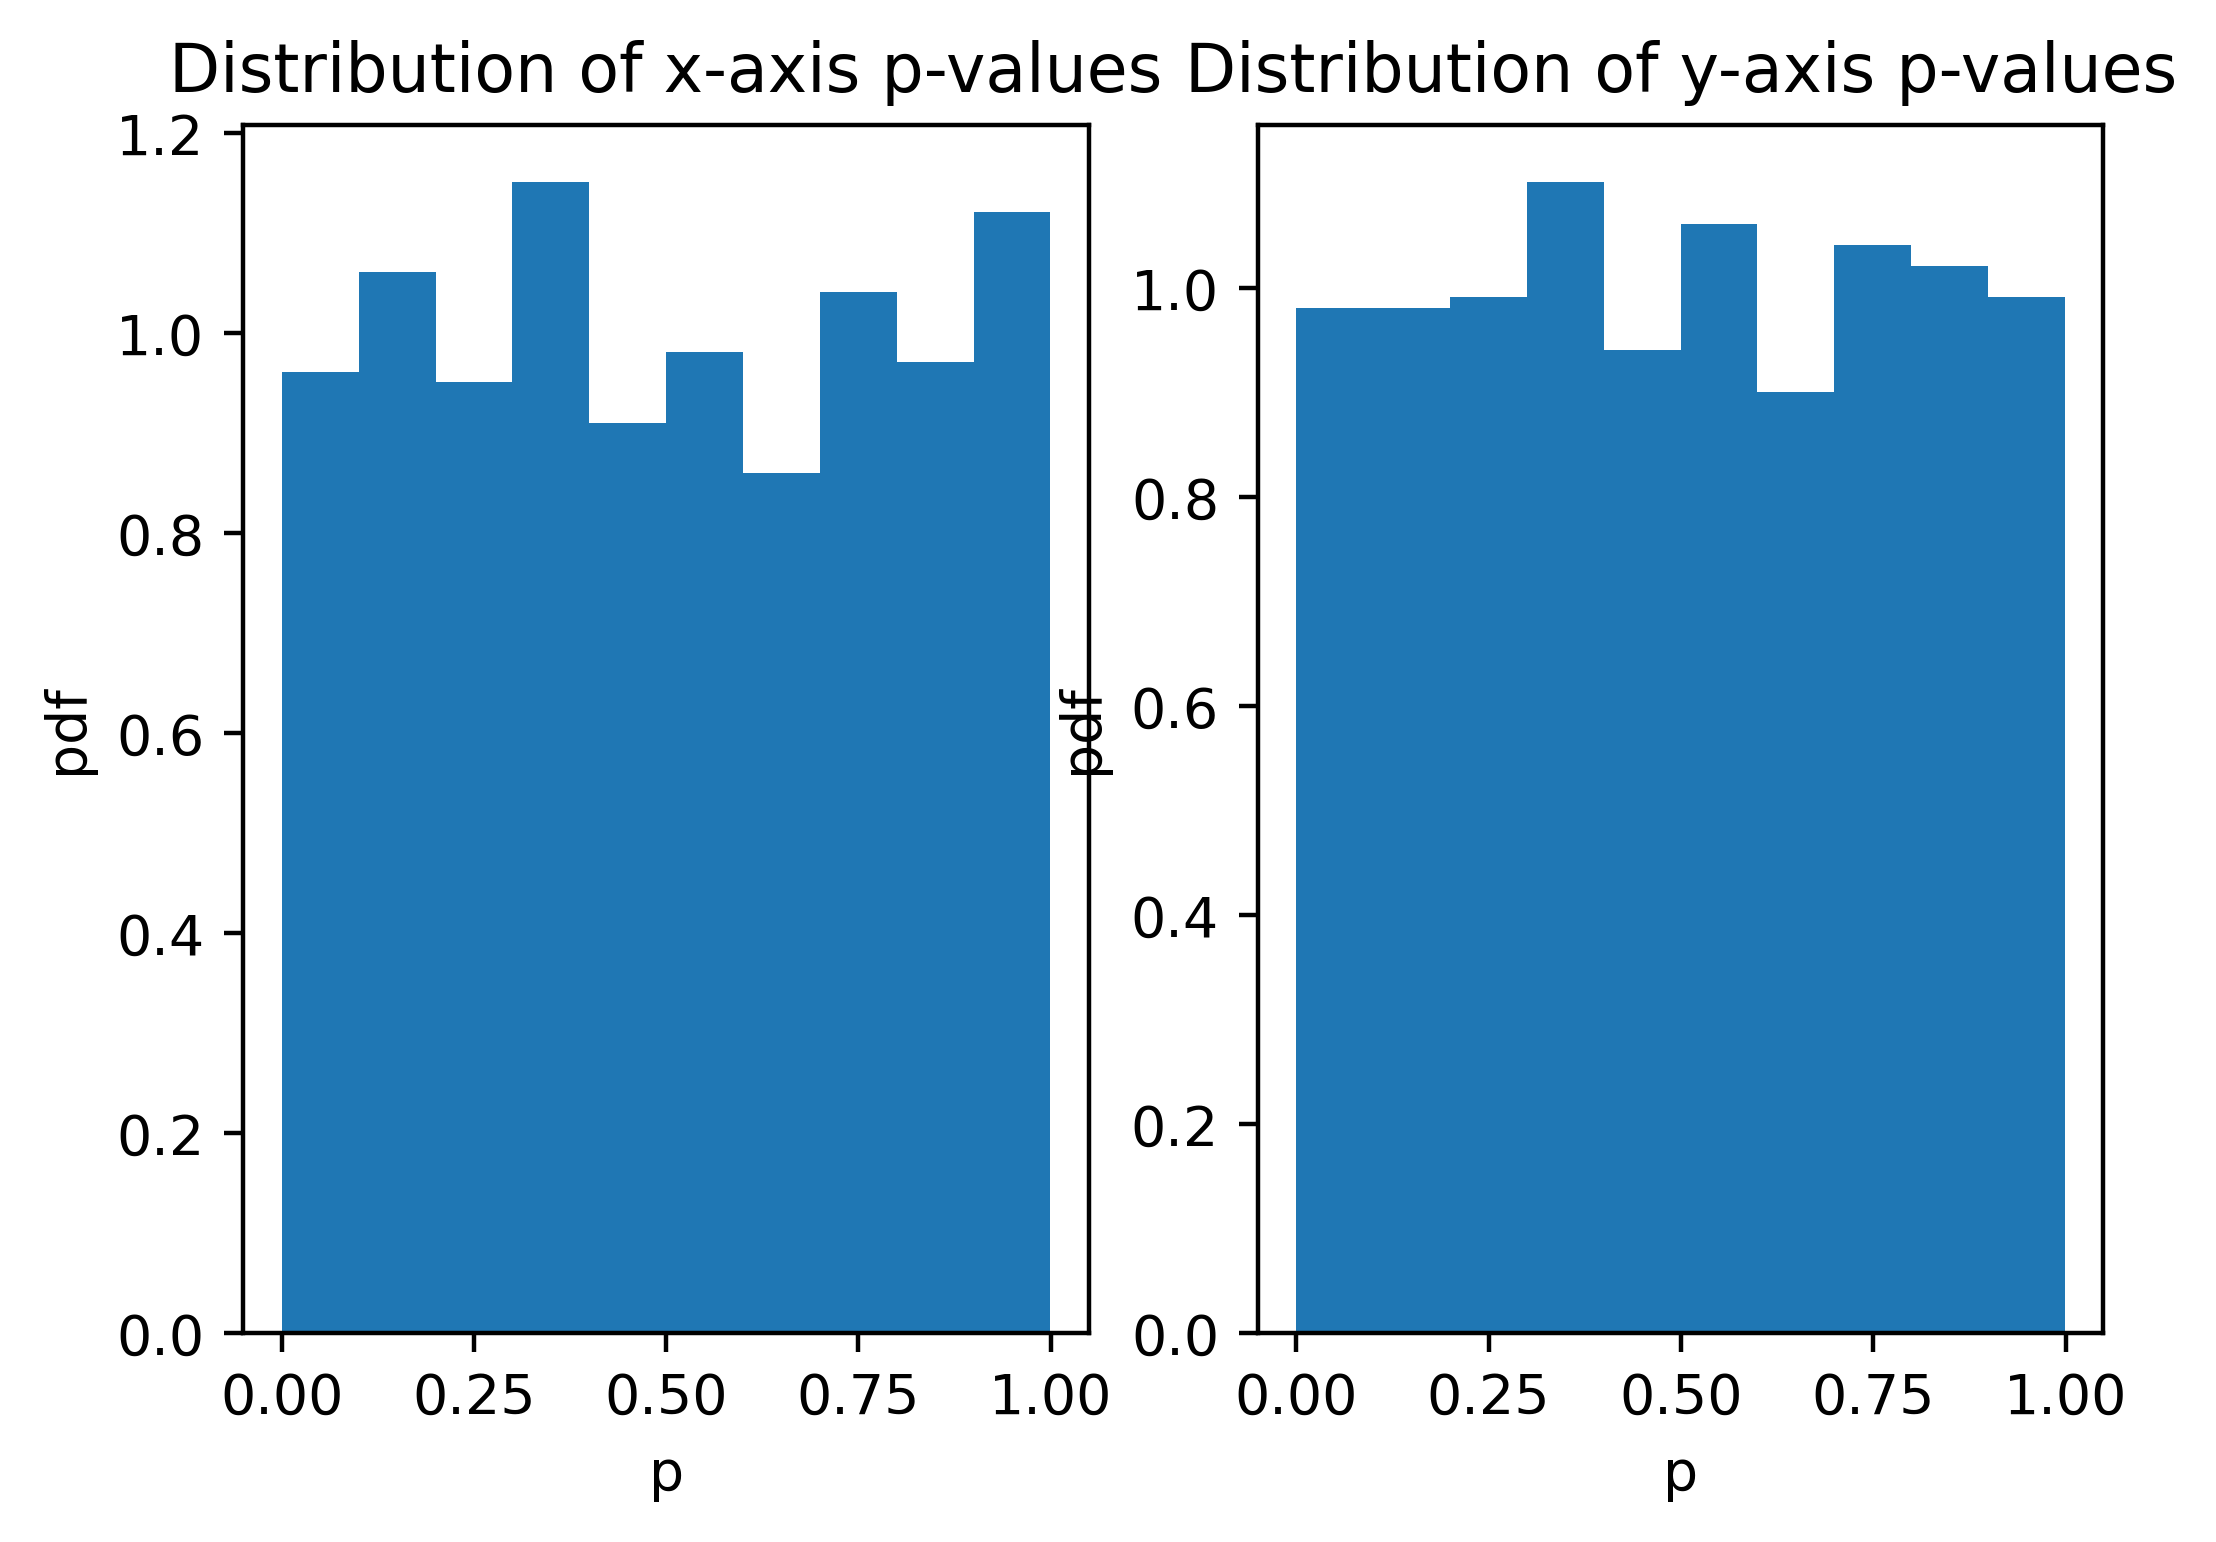

#### Dispersal Histograms:

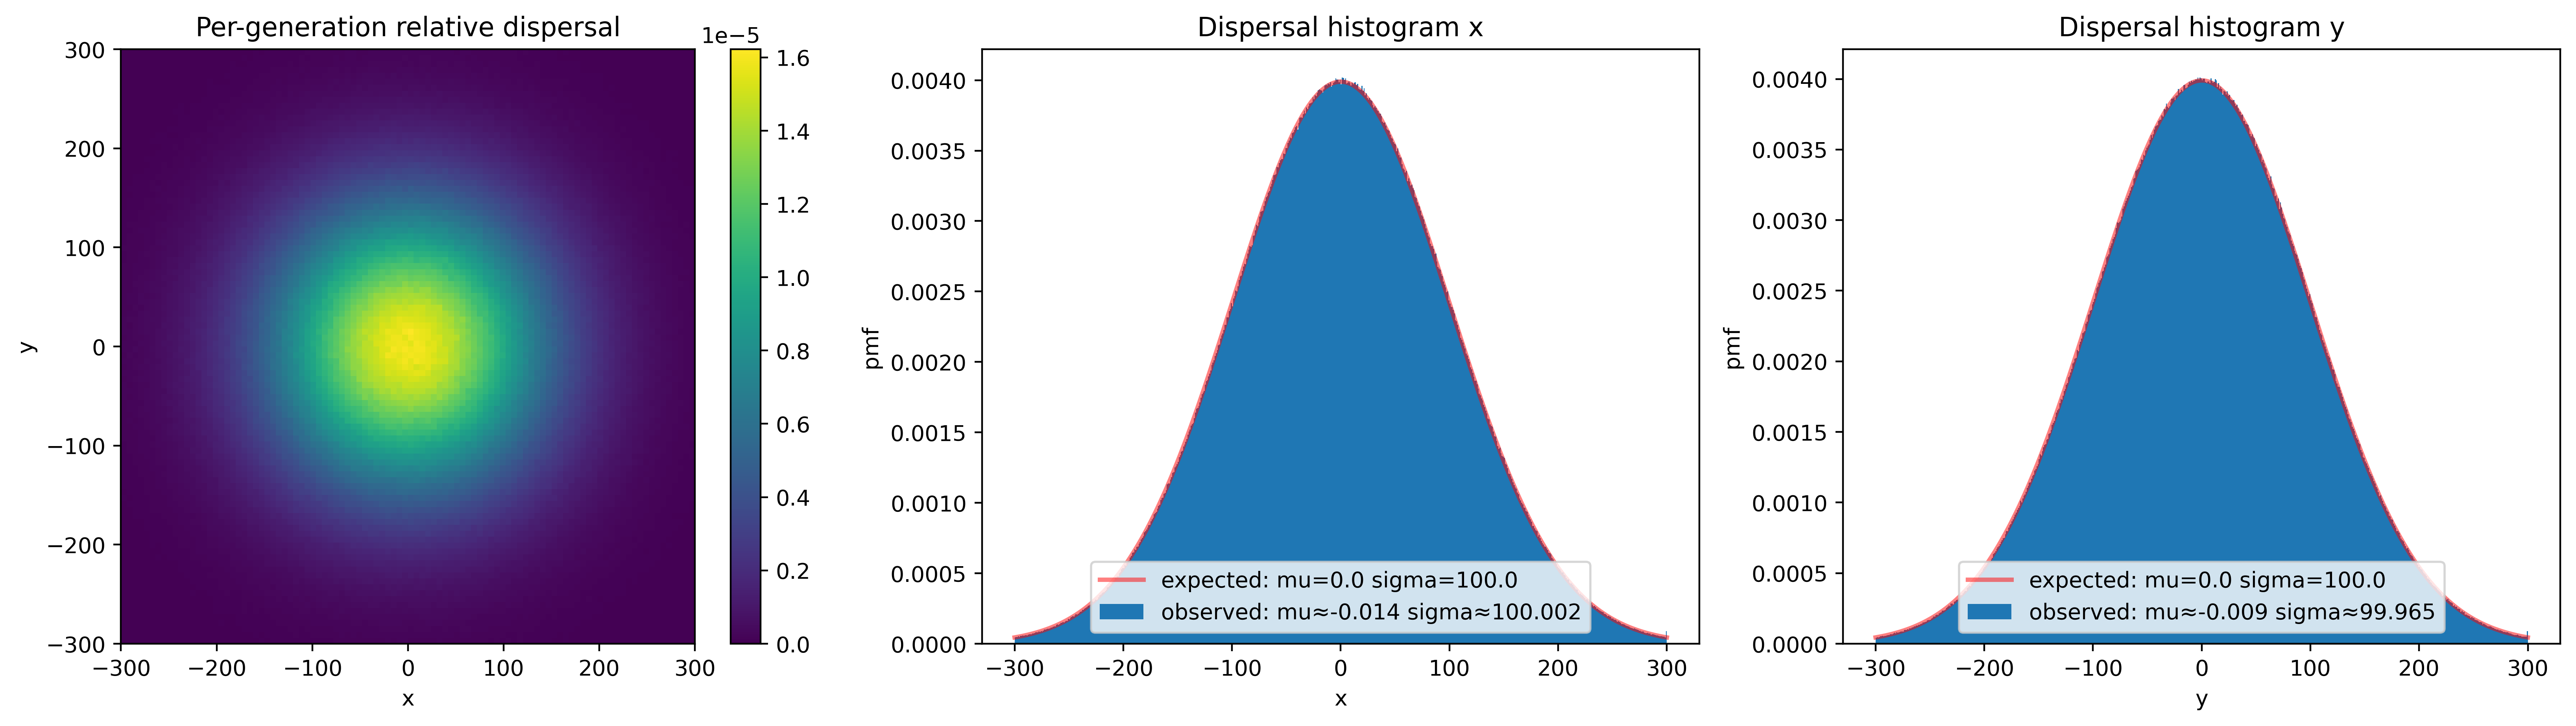

#### Parameters:
* seeds: [11119538249199612328  3382724606752073247  8774169114802312733
 13262407920119760875  4437893652752211653 12020270480659110711
  7848593259468043539 10974577002641825057   775833366039604081
 18102009536410055552  5654760823149820780  9667216906267711447
 17992021522416848667 13525022085232033705  3884768569456703718
  5538664347779803091 11376166664555327332 13638335251718540770
  4749249956426798575 12744805596493270932  9851860879899407817
  2038434668348018252  6850668248749461451  6702189427398344350
   628205379414072631  9820747757930694385 15778098561165079574
 14861802692443872098  3251200383633388184 17007710404311871496
 17187503554988491146  7177674494970401874 11789765716261396660
   538248891855251341  2146530388508810736    45870580335554525
  9410179080102450529 17701538795678205338  3450006467157930982
 14557690309193568296  2080900979197273660 15307170903525277214
   305796613377899169  2911153013876501074  2008823805757803556
 11938829090071839728  8866617112278286409 10449649641981514707
 15328352953815791443 16999482180436689632  9237089451915629038
 12056838872913425483 18423745558132920406  5421529967865477628
 12101564501140883202  2822517123225681718 11272850842443391854
 13956892688138790065  1590982272114197970 10741084518384362130
  8919128923330657751 17973943798622694577  5429037790582916430
   417221061650093755 17127922633025367969 17384619316283782007
 17198348217945863211 16740340140508786733 16357297252103983929
  7714089328206735977 12930177181982487711  3694190109276163086
  5764275495151703112 12352439594375653242  9772197163961432829
  2441052315256246686  9200155278399251684  7927351913173050256
 12654445535148232020 18360776339745642793 14025133757390503502
  4965530076543730355  5580440045085418112   866272665859727922
   373936621533543191  6855663940796032547 11657488841516600586
 15814555692957315114   510918559070187252  8620053753234407137
 14781649343539412600 14057681130059573419 13657617255686484643
 13192619552045152994  2982669863542203064 13796346735255964919
  6272013891657673439  3585320282688776202 11360859245156600026
    53296960924046898  1681911133995276763  3891131544534660782
 10170630070243279376  2327613378542144121 16949437087775934944
  6988294039847442287  4760964150664373534 17222540780123103908
  7540212943841820965  8007865108739537166  2037388397169991621
 16055588980770829104 13371607626111117247  7500077835910083239
 13264460879691501926  1757374791910195088 14455739695321883889
 17811338152821466955 14592643120056499376 11961791917394795283
 15214108361107356411  9277376777154177750 14513285634518690631
  3280863249377602030 17468010950306374157 13542878022257267918
 15430638272684071655  3179172508707670867 11147060714831117140
 13146263210311076496 14237331344375169770  5922431537346540683
 16801593729063980958 15913644114324040242 16846525284936888215
  4471054277546848856   492946443066568300 11160869904712353030
   638674504374762648  5807454270089137163  4474824774881846201
  3570820285900557223  4136450573890338797  3395300310232557508
  7564423549822860356 17736981893492972919   437788492957702581
 16085333407839489524 12021026247698389673 12550526258103029362
 18273937305946289585  4812664492940873249 10419454149377361185
    34554952220718452 13793517426123260886  7742038468536444489
  2997228292437965754  3402891547585522583 11934145142859717674
 16844247800451755877 13207244334369402067 12125439283276793647
  4481254156262518358 12365578052592192274  5715713513283792813
 17940968744061347259 18387934837958181688 13859567481036293429
 17778653925013328653  9534077956463090552   743826891643559679
 16224276731119287444  9494192224658834770 12559865377494634902
  6305059434363664010  5272404940520959961 17425432499364684892
  7460017439843745052 16104134786597298876 17966611891261010991
   789341702708895925 17372847389808075548  9033104132971201189
 16780747296639337236 13518070368608256718  3876950631496534473
  5104077536270745810  7291664900668962805  7567685633281254528
 18398637097871144798 11983839106318401505  5849205586937607027
  2006569750891570676  6258662784000560088  8739889957480690553
  8454603626676881199  4859568979373848356 16658727460917931119
  8441543894744530811  6991490644139862317  5013980212189368569
 14390118083436967320  7992086675891416405 12809302062005965292
  6622024423716287141  6052983576446164262 17003259007683478444
  8006106815066030915  2220271583884326885 12550367499989308978
  9054341503658990444 12585734871180173702  6990231677292105181
   322818552576389350   477493139677614194  4083441324982252201
  9261771785999695511 16598305922441005382 13967167500790890198
  5920333236193433294  5820711678789382275  8682333404768519096
  2362981998394550661  2802555648519778499  7856839034170520091
  8229438072950860449 14945237865457623139 16884824879907527242
 15702615020791567668 11347582399464772272  9668895517200123874
    28421449888987622 10175951782282543994 16244015503114142183
  4702661161112695973  4181930709015841793  7747752542756007241
 13464224791230877749  1921132503723000582   606719109955505570
 15150418748565970230 13142495334906567650 14852588813417948652
 16465180841347062359  9486524762108702288 14804434090580999636
  7073540058224940354  4412910673760939551  9490246865291175442
  1040747872232480193  5068759715865930386  3375548300743454969
 11042204293801107086 18039929418278670846  4119182002844000597
  9716249473358162063 11974966311048275901  4721685262014289055
 15586854197000624488 13833774081577789060  9704893276930131975
  4972219395736279887 13129283842926917184  3249337598418284498
  6094969045508722207  3419946471753686870 16710317072486044967
 11165298735589162590  8957530769913809888  6917794956402481443
 11596944617366837421  7131830746433220997 11544845907388917318
 17438956944422631349  5094738868147259907 17071249851900259174
 12075288615631328326  3981748950503606778  3579738500610291610
 16757248784484854720   906015028716204050 13790670644047258581
 17911867626922691483  8291552847822784348 13615591058990678404
  9454551470520517416  3645022930902588878 10569368911578810202
 11894778454119462467  9022665831670230425  5822854238882800077
  2215971193643977922  9855103351088354388 16225181743246568462
 10284372139006759480  5343710404789435197  8741370457882316458
 14884195812820400833  6191326404149992019 16574983489539433052
  9008963154761576758 17251609453291479175 11891642307091988348
  1252463131070657607 14936381147300606918 15172187243639055234
 11738665082378306797 12308095390493271296  5443190212005826170
 15374106771640525077  8484017588732605477  8369578135129455919
  7714796010235527557 12643816235833171789 12312187755423625128
 17972631737103648171  3401942280057076187 18042574275374926190
 13190619865380172138  9670605197763457690 14518255882452361921
 17214736080956022615 10968822545664116056 17014715497050619426
 14628179573662202868  4437451293806838514 16927610792229256390
  4068877076753195175 11170902095676370124 16688339458914555569
 14135489606490445343  7418858924347923841  7497462515598803186
 12757423352699887485  7830112794789444228 11411066069128483895
  2290787320536856216  8374804018757105153 11866526909318918362
  9579076489974733779  4887310787372422280  3509047072177506021
   184974107874120413  7445709305894173973 13567734052183102528
  5829523557008367069 12043974002340158369  3686516081760744551
 17915260188007348802 17754880581856365298  2263503807536814855
  4002503953519945791 15103404342327190532  6109622286218459527
  3901073576758770292 11218621906016438210 15970963995548543945
  1440277398387890652  2153002099550549325  4684418154545078796
  6349268867923102062  2361381323643234847 10325183417715960247
 16991096301323243194  9422461020628594773 11211953644588182894
  3319552110936578653  9361321692020515069 10654577226698340740
  4705601327854693441  6154315351961749331 10013800045371987240
 11041488062906194487  2697420492071768891 16757835009949324806
   135636229955028180  3838347820471362625  3462247663036971992
 18110543623791700901 14185868093292535254 17294914610749676517
  2229587796085414318  5019273909960824248 10952702654195402140
  2932443612184448061 15731378844638149732  6967359030708573923
  7418768584123137467 18245665981962445227   715080888871041915
  2948260028022405260  8153476965852352084 13930577962244569136
 13063654420560583664   856910626974588941 16008951281503135470
 12357567373973910636  2972098298001140602  9470223536170274410
  9015553691161001054  2847225642786050850   631112216012922116
 16510092605985475527  5122567142851841514 14701011033324941196
  6024422831291093906 11971649760952251364 17107253931411033351
  6444255845207440836 16597821104037518005   622760316314077543
  3893718484436612475  1474485945584253143  5786029774258608913
 14935597444162344090  1265369776405420628 10086943873857750278
  3628134532233239181  3378172280493838235 13613272865063067107
  9814485605704110630  8617486605847959083 14281219882181623495
  3847375005762243576  2221220619643111258 18354558736289759168
 12638960825190264212 13857774996671707021 17270706072747237358
  1935649709497919214 10962037335007217569  9447990801236107459
  4503609491731873049  7521758464979637087 14927514064453907398
 15607358241725867478  3230582522423735840  2617285939477866681
  8141690454007216578  9346086108471300108  2932205749576679448
 10956489128586752373 12261340838189754279 16621625633591474259
 14670282343311110314   761553787521709255  4048072506642144060
  8089285613762126600  8650363560897950517  4115636531022184395
  3120371843278677495  6695642261702620796  5075993702068435120
  6580473642549554195  6390181204620470932  6967340027079646798
  6400911549786901651  8412439936702179537 14596841555744709602
 16025678094486174825  2655550230363577351 11088258270057059290
  2084115790852983832  5036758106046465859 13600086260263948911
 13365742451563626121 17051971004208843894 12587752693670753673
  4418550317453409080 12679981192916564937  6095566522656331218
 10390514360571441747  3705567568582371633 14292301952169272755
  5541375314641965260 14332055674317680205  5210515732554516641
 11913829206966399083   450367943837350139   827459370119444432
  3193722662937151719  8071227273775168199  1777454647068847979
   270351126620221096  6523831611401440106 18342314408951513989
  1207479665916941737  9417574625361454250  5830431157092025208
  6545278532151356457 10029395959092762490 12960324994454559162
 11363287220285862119  9966823939494855526 14327398800520927835
  4554634921761544805 10102218283420324846  1007951165611467874
  4484664362572105014  6906389503015091720 12606633988725161536
 13988927279678191271  7693305955660509836  7955836448310949051
  8057361559879761080 15496280104514016963  7223015590364517099
  9084191477019326386  3760090052410190022 10781223985004932231
  5485337848988954599  3758355713314856668 12499821556459500377
  7048308570880137097  1398897852373788192  2470481157502964219
 13423498558702757835   417267515464562506  9720638427516263859
  1200015644008958597  7814828326140664328  1952995658135577648
  8351481078260217867  6019821263916866021   162049135929122428
 15616516534322748103  2876469235641586618  5321502469526728952
  8865701302236403831  1022057305525157791  6683468371584191126
  4586760265051603852  4629270922278469942 12657166238373825837
 13434105900630986973  9538106609104215700  2388108251287900756
  4681690539789262132  7089716768426365793 17272164491461684540
 15612727086317605190 15355464737323190289  6492239733003337364
 12038588039634326520 15093897089961635360  1826076300494102633
  1038910144575932606  2462956079861170776  3709256852402696155
 17436170311595105679 15554983303933742607 18191703914802248414
  5872422620572171287 10011316480829269934  5448249091168783542
  9402062868598725724   514011315382545443 10520331287492109619
 17831452036555998084  7499791395035271163  6823085401966915833
  2669775793146763714  8649420450781950424  4481655028963533182
 13905286164598084037  2753430331119605001 18195152582263315047
  1764778450199759986  5997231318704457297 14386321902866652100
 12253612112935914430  9354823722684657916  8418552506065820665
 15210295763408414723 12730784788789899751   729400065128082149
  6872418248935487724  3977612289521009116  1512755730827052749
 13876806256365245798  3096267191930554894 10172274061874959088
  9398221095991978742  6343669378657821467 18432223922849011456
 10309961568704560370 10453156240576137220   754969435177276277
 12656803227145166114  4331129905555044071  6632728051656973963
 10010575406753599260   855821208829127171  2670589637501146564
 10851467024795780630 10939298177701706920  2957202842792221785
 12774958945874034612 10865346896005395842 17811243092851667607
   274280964834779449 14231942646845289763 11210210618356230109
  9061348222275181367 11238308170822261525 13085662940066414402
 11388461767342546379 11110509100136280577  3621509586799084320
  9723338028167543817 11347525995960213747 14159118355506798352
  8722596023106695648   450833654360380263 11581981756101981488
  8981993142169860506  1596510243169394167  6286952571050575059
   663935586547800194 10272372336500779745  2412952573933391474
 16917452108199440056 14308142702423988964  5716956637922650675
  6140713118658379394  2271024750633755804 13861163236526407240
 12126137645382396679 16751052837884291378 11565261846820070359
  9230224205781236167  9545986658862682196  9096079284882825540
  6719090587808764880  1726254265845515549  2203440612056820399
 13752570602641849430  5581483726423333280 17556222592442879089
 14674164898008546085 16498986392413878812 10351387505122102191
 18259399298860788030  1917553521105481103  2209467322578049174
 12003452657755557081 15447266878907235051  7397387050090527441
 11089145645395709972 17841100455705886639  4195573369472503913
  3155816714621314649  8257066285942506540  5948955943512045443
  1535383567525301878   202472859328016395  4584107164913554826
  9846461927106171637 17518475174441315049  1093996709754699726
 13169043235414153353 11312479718671035358  2040722391712258527
  1353384342085585818   784119205023511021 16365139687140077870
  1792084328988186279  6403187371047771777  8226445679127321402
  9060893235308210750 11549572951852710233 13411046253868917574
 15470686344112720230  5932393104065064703    71121340872563368
  6483946955488142887 17492013273434537502 10604679375004556710
  9748582391849338555  2261896921189387330  3339132315378683886
 11416231977233216816  3833422956075177564  8884776873614774279
  6336350334656035441 13752316435305219993 12143788232857874092
 18416593284302727927 17807748345308892841 10102501353092681922
 10088273967664312096  7533605949032831433 10446875307885881287
  4666402130141591774   161038610896660354 18256286011762521722
  5759079022058402222 12181843642680814153  9621754341360317716
 10307909034314266316  9657145301958599639 17476824703072192698
  2376388685965573714 14728775746861831173  6211905634485490516
  1685106232962237601  5205895368900017096  3504635372908227736
 11918822810135688710 13330590754019325564  1261433422201857699
 13621954502780435340 10792394565224214522 16048521200784465641
   403212384153477018  5111912300524310131  6534505795673904340
 16324106717685541771   746454769255400360 14923228269983800086
  3210649563412395414  7033845361774473465 11020507410117419162
  3864720618378730147  6867754953060507247 17862965100705960539
  4691189171300568021 15005221769885233967  4752802828859205816
 14775394469917017097  6965362301863302663 11295953682850916245
 10108786885509659752 11781044996712358423 12310116220975290501
 10134012664796521948  1616188104691072037  9761506395579438160
  3867350557164645636   406423958669383069 17475942277468091535
  4283335331239286718   567391774247648757 12690312965620765375
 15214748651271827358 17465763128975372500 15533435049190854504
 17616846919171398925 10699125452255929723 12140557762265637351
  7559441477314746568 10224797532727335738 11852175531708863289
  4620723279305531804  9793223628294982541 11191629153513828302
 10544295237786466479 11918834920921730952  3622370686130869935
 13630665364521076738 13369011639561638874 12969682937819573689
 12667062785294842173  8078442029409474587  7083789246649235553
 13219961239718884402 10824317378475545529 12194300367437375627
  2634245375464557860  6915568063175771454  4779085336293067000
 12046794192968260454  2364404209849801520 16393316554079824343
 17349634090351827432   338965247791538239 10607674864271279905
  2034814413702803373 12395795569447898852  6733965599360720780
 13399416160818731808  5569869543017267475  8452787716686415517
  2467904623191801191 13881779156367318169 15814739980795416403
 11389587881918023221  8180341611121682788   349167558093061553
 12680610772126804443  7736370240198936081 14912487061471291484
 11406197628502578391    89835006960799863  9011377975858860191
 11643566761077537610 16301222243784089666 13148979581378620603
  1653586258906576566  1470579053152387445  4428562858659415889
 11103022419499755336   348411753723699054  3436656421277659865
 14850654622861580088  1201753432825509695  5690272868348816072
  4486110058776516001 16351046321157011825  1896446982747023077
   327979014720990123  3687855069535014390  1063479881831990753
 15529983906296326577   300220307509198798  2136658728119820481
 18191567925113694104  2995509188189941283 10212336182770917722
   948380940407035419 17427736972089885827 17621519509342113100
  4439036684706752297  4261695795804989014  4292650050428266969
  7474988616741055379  7577928539215301664 13899108215789237044
 10477050624689143871 11421501836587781457 16055362652472994668
 11321092069858312602  4538039413752637160 14343096996757894928
   249998240835424017 18009691731687411936  3389278332603256187
  2432145008210632050 16438428791089331874 17552321921149049643
 16336963993306414963  2528374456575500430 14308177649119434218
  9204716942865053726  1634178861334213067  7675662559116688041
  3411851278586188230  6982791575905450135  8289613447441202481
 13128754755757310073  7677806852331151465 13819687465853672232
 12169519050722240877  4092081761952802449 11572304138329976012
   198610659808478496  7999289461305257783 12215336741574415922
 11567816216268875511  3518635195994302602 11925206015375790072
 14845988979795931961  3007130019650578733   620513235583344914
  7177152363007887321  8662928353906051876 14127755448397508195
 12189016851743904259  7792247701116801851 15878134603770502819
  2420665026687575448  5468874751926647762  9265122819042577837
  6498316237992887237  6858577398932856800  3197911649986977272
  8905959373025239449 15130898547628759709 17996535850351693774
 14834266638208033815  9542951869201181111  5883107906338569431
  8192555395251208227  8261979321815973610 15248203224792253709
  1131713983903438377  3285807994187469810  5627398770078806244
 10316787939451362814  2484908778701468125  7443181409286448513
  5737227366820106690 16751571135114594579 18207730341068218179
 14746977401552427603  5208925694535318195 12996925082277635031
  2624667466947531578  2781876529835882695   382127725114474950
  1310073954620870338 13624780129136980215 13067774267235547309
 16476275798383214343  5640407567924858641  1440291393313453830
  5329496723931674301 12457543667005532727  5895554538160579318
  9700779664804401557  9742299924791705676 16114913402278431488
 15419338920661414558   396009444961983084  2899370678491252061
  5582559226166472822   197086760005646235 12084612920879747429
  4116653883840005817   682729929254985199 16904774895804005882
 10537785679655235778 11669973440432892086 11510908876698659625
 12527046260796466221  1185395575920837494  1994110281862457568
   621167786609951735 18281162883916844536  2380211988773574427
  3859362766303132716  8028683569637734524 13543644593044016964
  8766048280286290552 18423773076616164420  8106135459346266743
  7533904914756467667  2727271788235125882  8161200693099259234
 11877636815984755279  5165958795045407024 11255495082489222817
   904601166711299116  5360452561925119923  7550581765976220462
 12918522977393911570  4387075264175073772  9642800256802754923
  8681638182500616522 12047994003853558400  6539529377043163351
 16918335859792188362  3502778420520490648  1727749467847776829
 12082391188732585276 13753764323513445199  3983461275854733709
 13867568479660985338  8556626249982911609  3273173265396769856
  3498273567669060627 17533641738420167480  9328530552803582932
  2259265965136500950 17322219073305814369  2524971881734715773
  2368741132728732979  6604705470724977063  3786699629828216384
  5637008623100286216 17876912301219661661  5713984428745234788
  9056355873964933400 16663247971812074995 18063977277848430665
  7568313927260985738  8072749766203453348  4630146815215516821
  3518182498365259544  7383322337972006549  1508068006592584629
 10158467086752019420  6538040691375587776  4101774689033681853
 15425724133826393242  7458152133980915626 14395661436090775040
   984154277976749913  2665431712995057692  7717059314248773132
  8601211615776523618  4421790818229028425  5826785151923138972
 11119334358591020310  9478115123377280717 15181519846965346261
 10888350969659207225 18182064460042893244 17673301758354095989
  5763335840900189662]

#### Configuration:
```rust
(speciation:0.01,seed:5763335840900189662,sample:0.1,algorithm:SkippingGillespie(),scenario:AlmostInfinite(radius:25,sigma:100.0),reporters:[Plugin(library:"/home/ml5717/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalCoverage(output:"/dev/fd/2")])])
```

## <span style='color:green'>Independent</span>

#### Fisher’s combined Chi-squared test:

* x-axis p-value: 0.8859102908594728
* x-axis statistic: 1924.0983888455191

* y-axis p-value: 0.3861391096696224
* y-axis statistic: 2017.6887096326434

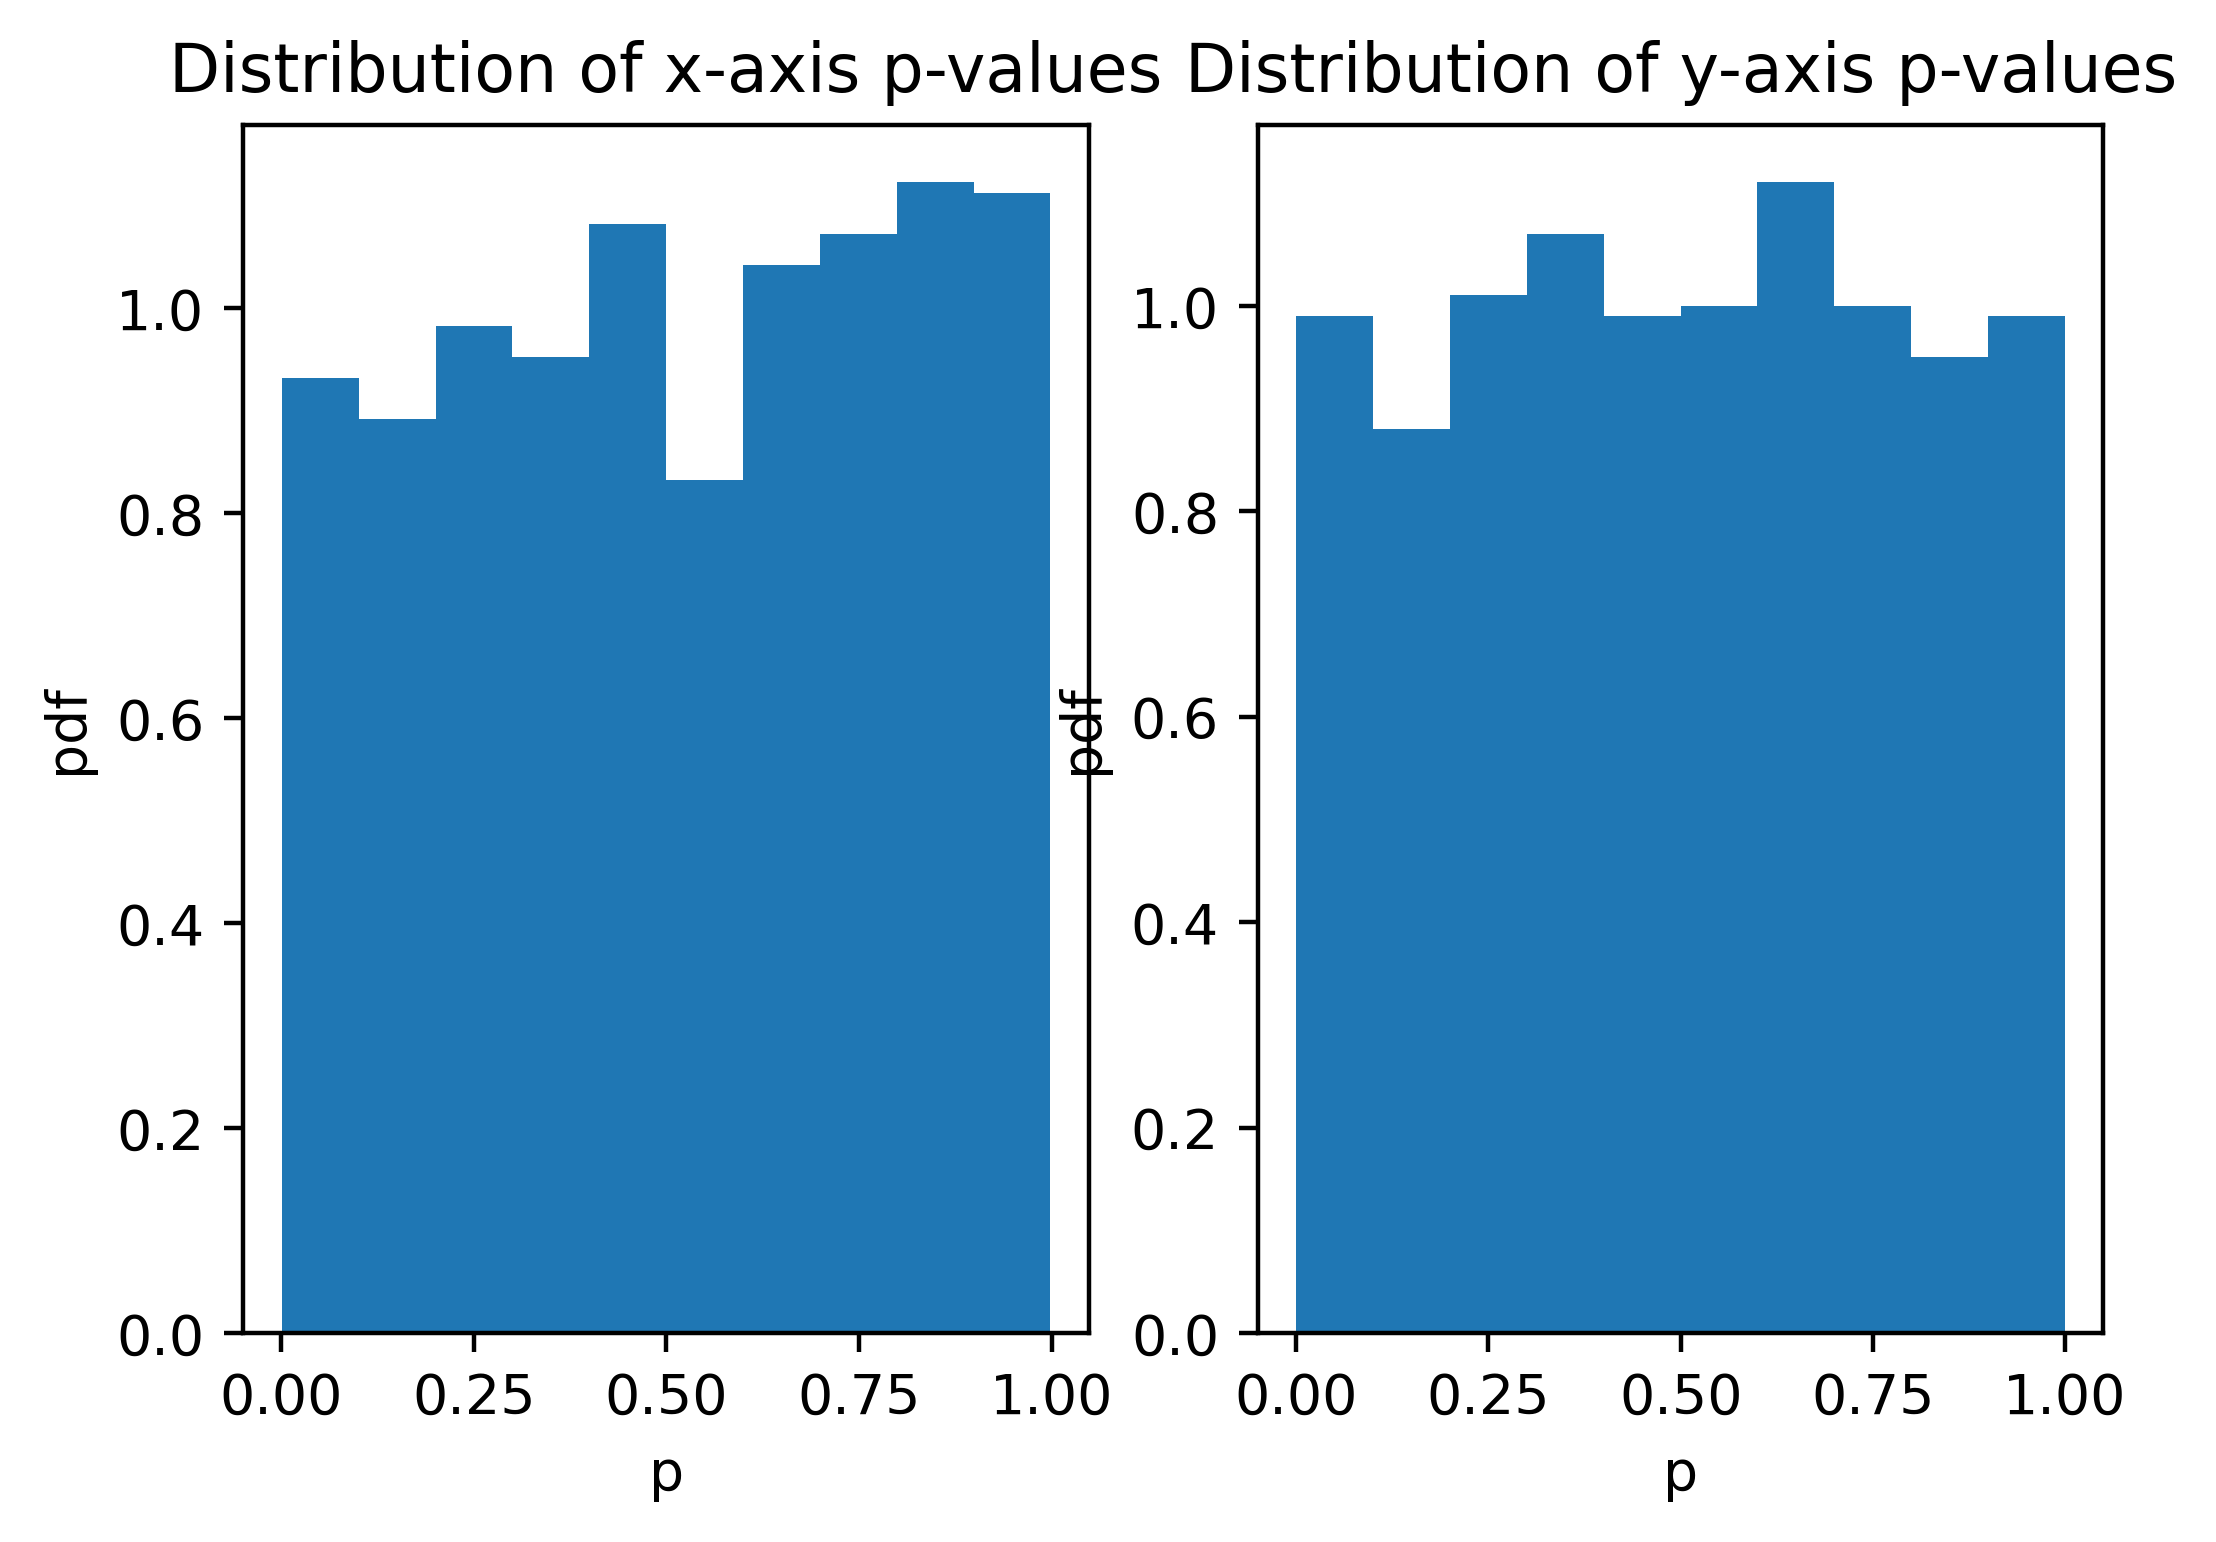

#### Dispersal Histograms:

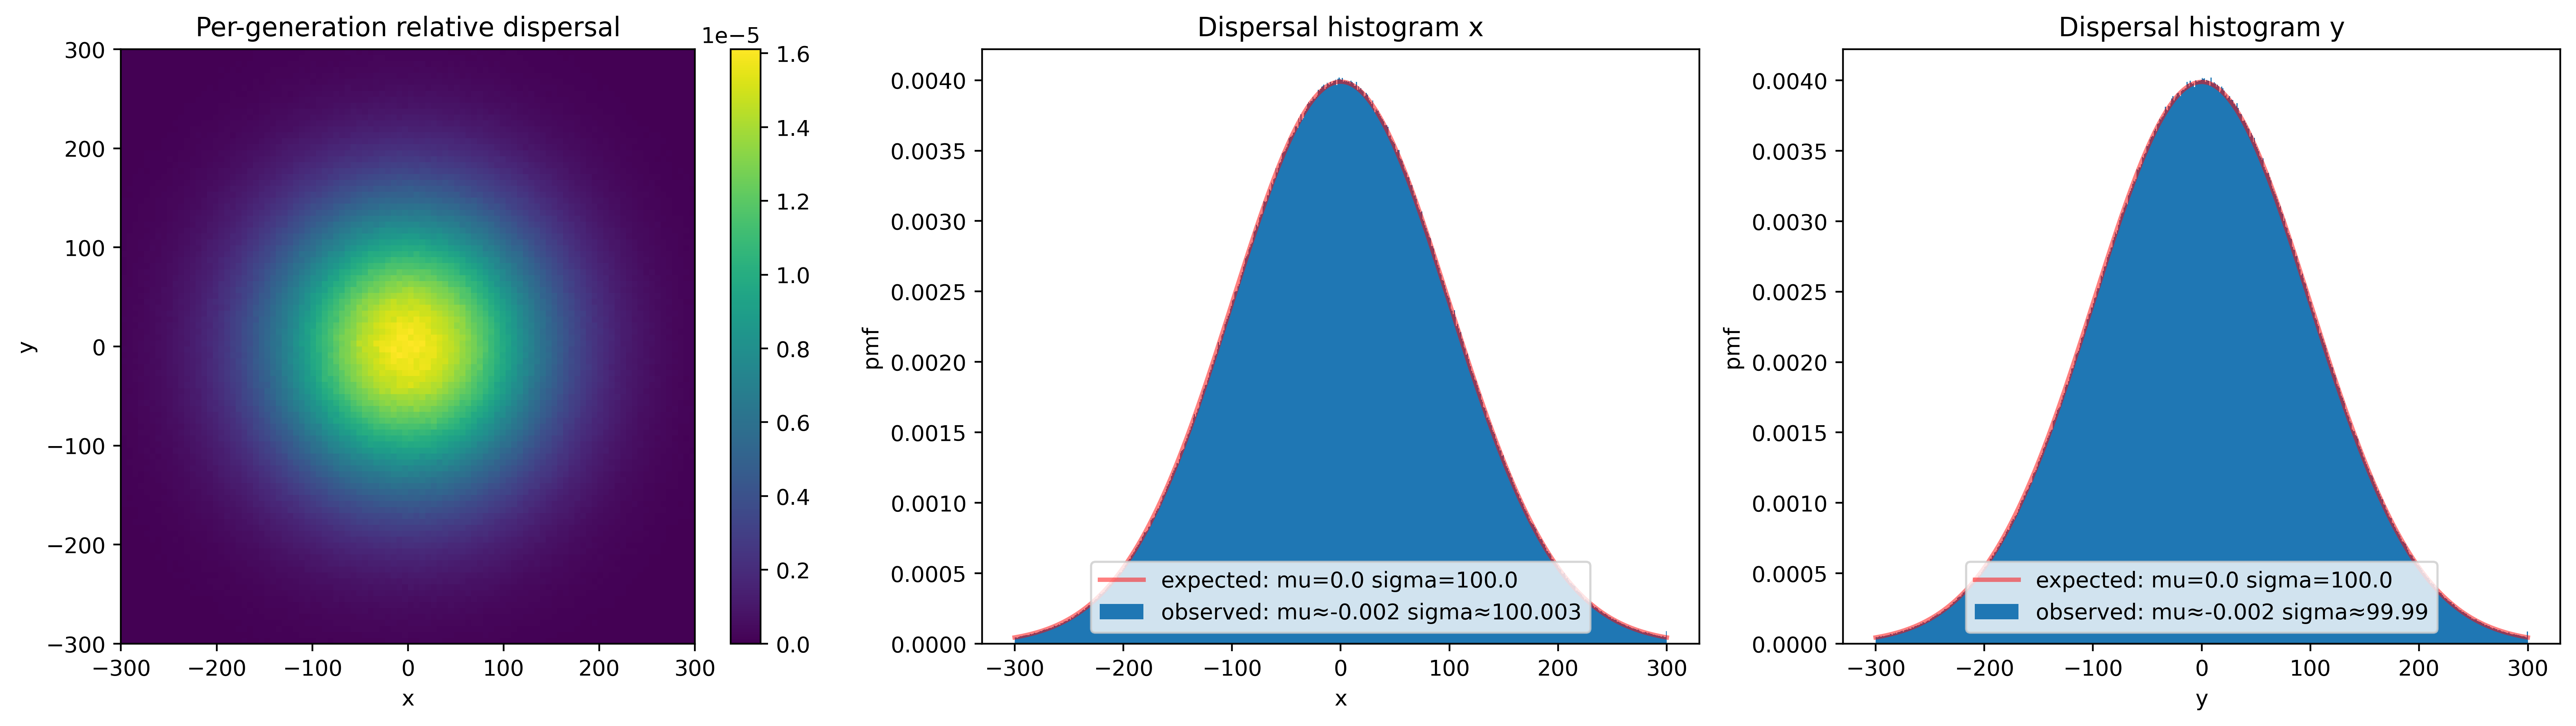

#### Parameters:
* seeds: [ 3611034738401279534  2936861539790818057 18168812872622560772
   854137484714336371  9489070092852110740 10609332114601739902
 13892071951746237372 12020609560936176953 14257846776909882914
   376121180565910563  2306668362231889306 17608103206498139392
 11411883099147927205 11438987649924465926 15890380700617974420
 10537297440861828872 18044604573947411575 13917952097108467440
  7315317033716346600  2748868699449300159  3867156295811688061
  3287666173541244590  8969553891977639439 10737568550448813563
  4431609896029690385   788931875247380740 16666751884620483383
  8988196836256764210  2452176382929518529  6870575814689889562
 11450271417051443821  1712455380245321113 16018329630486084256
   923800513102794227  5374008305180339362 17022216006733863188
 10828255928552356974 18419086487211386285 12246431291570956392
    41864414548455974 14038539612289249358 14074057118219470198
  7171413335277499845  3874236030951008494 13466695836252105884
  9272427270636252969  9773095032823178633 14559811993505642570
 17953148407355036300  1083400280827539324  4899283047408712880
  2216381756982156058   667688321642818418 15543659843171120757
  5592680238819906133 15811758256559275129  3921231490915494510
  9371882333694949068  9271951795971260489 14391449543865035124
  5192042273997046695 13798913128249081128 11288171459759101240
  1059534545554504704 10398262343750210093 17380099795711177149
  2987937476159004214 17251557171959236489 11572031694066170577
 18166860201912863235 11608661152866352278 15391017358599486223
  1569098894031379818 10850469397757298822  1926184130535678052
  7644986075184170415 12586167643063562074 14567160679115984367
  7608465889679290848  6811837694624312538 17175578641373633867
  1411001113826255390 13482798562920046426  4589992350707168564
  8511661985201430836  1525544436309277546  9327323104205770485
  6029162093265223036  2828770254478697473 16718736533560490448
  2147483131551614484  7487851376557673404  7872569486818572035
  6216953325921606515  8712499977511229272 14623493174348804283
   978441969991950708 11432880074343957707  7437316615401115883
 14157921910938864485 18426650153904199197  4987489978566266526
 13748438908097892151  3190317596590362120 15614041351733432780
  6426317091649548766  7652257734301133396 13046212086060382707
 13031908756064575411 18240875532140196984 11057672001722113316
  9956613398810515893  4194413779170719946 17075191183466063713
  2476770092082057821  7391327339587067391 11545830211480834188
  6964433161732885837    54027011321111408   235944012175589737
  2261944515192563674 17495917611547989022  5415297986182403418
 16178036144742189349  5093221360694138520 14089962330001432280
 15401705675849581782 17114938632127594199 12149673082840585454
  4186651639944339386 14863318574673874908 11566244436528327121
 13438874647581005512 16074031465592466384  8993749747739313373
  3540442611413806107  2300924076270751775  6014221137648326546
 15831505086710107921 11763506760405155717  6885559175745834740
  6233274924375882604  1961659490862601369 14124412705383048103
  2346735565571109237  8223945104697835311   620363315599447488
 11711364743259463687 13296929108481562218 12599470158514626459
 11992961530695004139   113347740018504811 15256211775184596014
 10769550259210270878  5677773515483708102  7025921045022507064
 13940004453847894607 12715468682677933802 11941345543698904225
 10763599821895636557 13039354194826503275  8414808069462676298
 18074914519317294588  3698992146191318707  1483337833868678881
   790091893019164941  9032978103644042109  8526344174209025000
 10176501944194720449  2734515183150636064 15133934703402739796
  2024296598636384740 10814108150952442897 15631500744797629982
  1291143341672014643  3232459790544103984  4719119970536046789
 12826013978543017620  9472944140921189302 16237793368533613635
  2664585769570126430 11259030147236113863 16247816679302351739
  8049567497152380505  6590901161146545657 16655138357753600426
  2238823581848318184 17331211630401892223  4994350085434879800
   970852314388582660 10311846864059853072 16870384933680797406
 11736576682582382397  2796202604657271133  3255879032627339356
  9516350632468161206 17302964134077571469 13765662334574934504
  3744240081153973894 10083343752988246396  7017685523391739187
  4687145450527590883 17113926355323035074  6884214103796672001
 15615993311847510912  8115438925018484639 17869770174866656855
 17053265793731311618  7323479312104453960 18172716796200587415
  1509665700526579413  5456728589562937160  5068852262882818093
 12391429444014020065  2171025324917875686  9081734255528278613
  5524205434094457336 13819675157201652332  4393624556510326131
  2642049671612426101  4223141496076862454 10139463723405814550
 13348669532213147222  2974512259740245642   980900141804419488
  3633334505791436685  6676622101266521750 11484636159622181849
 11674625106124072369 17346298040291076761 14825271208550666038
 10610383894839802935 10807002746314633572  2240364663928873823
  6452303842634900107  2567706436453217952  7587134017624319297
 14854422738110676474  7345131949190099007  5671980306767627057
  7287359377799806094  8017369101551484263  8634613399360627686
  1480568455583769471  5631301215868482602  7827210424614363902
  6179582265750554625 10908806327807704502  8463583583225989224
  4283541151747375581  8875711851729202279  9278174153919818840
 17802776725607434692  6983490400158718060 15861326396686438586
  1215010305714374491 17283622574549758144 14400246118279762978
  9720938274124309647 18001207719117329784 13580057164261033643
  2635202944527029287 15432379557415127419 10573602778301549923
 16038884537181678857 14401276339290295455  2439342933637311863
  3423573278889674405  4401947164386579981 13891681547930617660
  3781442386917011960  7319781825065823310 14765852705919668306
 14981989864950619426   636635315850592536 10773616022311763815
  5780551967737441618 11414787937754482504 16744830253713420865
  6661892586344207201  4145120052055510331 11181833436943458033
  1039756943717862604 18142284232633539999  8200418395991803286
  7414515288351173805  1537276680285291460 14910114564604839815
  4653850638426989326 15838186907667533123 15717110347644402561
 10627590160504286525  4377219215501881206  6399343480990151021
  4872984594941871096  9283164196274187199  9969976212041653360
  1294553668727830944 14074675469202549896  8318169904951940214
 15946130332205618734 11167658260241566226  2132384553348015520
  1409353354157728122  9827160576425407884   740828251475579328
  6089220755801548259 12293121552851570634 17564408438585559392
  3583657050709225324  4692340587600018174 10776033863697926170
  8370090743917309156 13878745126505574462 13405288508362521827
 17657279872963381337 16247438516195896607  5823364045232593871
  3617346773298674340  5097200441425233164 13200848531274861802
 10690315591353525637 11674891375014668459  7736371540641764097
  1149366208881280285  1624683720947658715  7631532193843757958
 11122364055319908568  3763583549244277891 12760120583713592027
  1463520382693181215 10535374422112892271  9359897756573561827
  9596065036855718194 12316599330113171354 14257971343250412874
 16272202496534603265  2061546447211033158 15183729239475475428
  8200227070423367737 12752357970616427500 16035518476163837461
 16982114120864515179 10114908886532839051  2171418052124910036
  4102598641951455930 18199006162052776752 12815192566756337247
 12716454679094905294  4552374518809627369 17710581991991260067
  6992120972309436416 13605936786004606768  7571066057640778077
 16696358674812403631   524534500437000957  2003546542707794787
  1819024334003921087  5733904168597709880 10897616149526673570
  2077605716388688245 10615026363786137739  2220495723121616120
 12944860872767583033 17782317079993784905  1078150655540435868
 12968896249260138486  1742138460296537752 10724846954971654234
 14405033003147993180  4987027650427509755 13157849117716996534
  8384355526861800738  6479137970129104649  9841651193522542252
  9476543939607261785  8012183938610996245  6670762544252953133
 11913395067833644087 10860724905502507120  8426198185813533945
  8423234972943480484  5316409073503470702 10321565676140954857
  9379679107434747195 12609088379692012482 10338501541173953684
 12312825708992787724  7883569854974962975  6999013354563999338
 17483601472395588649 12500027860363222727 16842983096573189992
  7554274374496328691  6771397545304151967 17338192358903609150
  8951396974264766494  5577679282480481443 13037584276626109582
  4389697221543096610   143006499743606941 18097951544788266997
  7931109021755287534 16986752741777911978 14531633011285046871
 15796637990993890237  6316478923931192859  7393411517055070723
 12940488960932149228 10652345802154799295 17858158387496278306
 14905616821643683763 11218188462191912641  4558116992444817341
 13143673063993252871  1735031400767595918 15009655485932384573
 16645292089494892215  8493439435942793638  1538523076833448026
 14392175183375544424 11053095270275889390 12763114112798453986
 16283369359539101393  4832975456448234117  7338636256386048993
 14404109845353420076  3480038340706620426 17613293756003170990
  1859812671266091824 11164622378627441756  4852669321350355838
   358365159927115598 10999249719160815892 10083756943918384025
  7841929334119972893 16866068256623880227  5059605872274810737
   390408976800834298  8091176211330445186  3827163634313064878
  8222904822659762411  7384295266947220222 11559467467935370649
 12701502384771328230  4273683835903859398 12716120707500839275
 16470939106630069954  3663871877445729265 18128751716494057336
    13634091209217795 17181796068094864611 17439927865793647102
  4862023959872483534 15064941035505641104  4056614115660742738
 11214893929470769058 10066435828990743847 16558228406854475603
 10301599341229903750 16801269465908817530   898446049842982887
 14023150890542858948  6964416073544976249  7922911518470446782
 12148312907746557465  8872945473982950523  6262974423737574420
  3714964818260073504 18210576305164600877  8963468253806545786
  5482942929347969002 16290866158763870079 13765171330311369946
 17598817479761730018  6363879164010291025 10716778409009013837
 17227784640176175621  7690102191329198004 11910728271308424538
  5633565180558258308 18233264238011458704  5202704392835307545
  1046823775063263858  4109360715585251744  1644188374958585035
   109421022494760048 13809237812087649794  4758814186138215881
  8179959664258357372  1854660927750801443 18206288648493001859
  4558471401171221667  5812356223293176395  4494698729395972263
 17593068491131838242 16893941188097506779  9884835952284914544
 17166427828638094832 18091822082847117132 10261876654287326784
 14209984369692240999  6135333151479228966   605559433507208670
  4550651654673846512 10792570913444362809  8728825049638692936
  5070777822297842543  9610439289705232895   102909786375002134
  9848353699596200965  4821952314065583251 13379424527402929596
  2562269972266323304  9170904410621721042  3767890710553216495
 17702350593746740701  9308471077759922675   450028031732099186
 11779063104692705244   871148306207182562 15667946327723075737
 14014725919299220438 10604543913569643629 17784484391838903795
    19055261726212559  6037163906648391332 14373300298132586187
 13168812151552240069 11509409199075151888  3012518579081421649
  4570494497384178427 11912612078861543414 15805399438465143024
  9639327271293153852   228814436892739383 11535124316557540471
  8681309818076049054  9433258041358949109 11119992390667379272
  5322624399654812774  2459323388030865449 11283761570132321114
  2016405882004803586  8077378750956740572 10032633955581473616
  3608252427542155228 14804755299465036875  6331390229734205783
 15770614099086108401  2756310673791074719 10382710304554124523
    95301539776675377  6687912195060909126 12759718674160530765
  3258721376264256379 18392581554648909006  7051933072919810513
  2333331564228376308 12172843237989713494  8295555288243704702
 10909064723021943666  3531781457905313208   418906283578312246
  3212518983043350632 16604870261752906642 15439026024018648026
 14797331720343156548  9495533700499913382  7970070991779352933
 16001889600881766963  3990388395274455347  8761059932317711296
  3324129851969064192 10866315243165838895 13106943170488323294
 16989266465161143941   546353432514501250  5729947823675152742
  3717815345347799157  9686400074374381151 15325605522859621359
  9716758015549970432  3239654855245471665  1857377267973190619
  9132392813340836986  7602170378891165175 16406935224774653842
  7707314425326556183  8501897374806425021  9521623184308951398
  3035943254559846955 14090875277992348697 12660020696342743281
 10180295492057639772 14096888707272145064  2929863935265251922
 13587388625153833487  4148641829893342570 17884242987356492507
 14469673425788035194 18357878463422417999  8401012950923494239
 12572397715265724720 10847690647601858428  5236964206942977407
 15714138380125451582  7217170227922899846 17107421525993596509
  5408644028819108871 14393871652002758455  8402605920446735101
 11251053307392126209  1565553495590957069  3566172779975007923
 15456099526997334463  5347547481209183791  6805011463521974188
   925005571569038383  3323303701492426210  9831132163602754209
 13594101474552080968 12708219318741726728  8704527563467712055
   754565738205280240  6773773989362198160  6489091770403385401
  2224896607356245253  8426662723075423110 10479852869840634863
  1730883159291155081 10160591108607464696 15530076950884215072
  9779190093921142945  6481611291937134503  7849766017062630993
 10842882552308184938  1912042861269962754 11164972193123497827
  8817053405880320524 12893907797195378708 17355108490082204984
 16131975549677815529  8634812792642884107  2706267038966536930
 17726977494833827713  9855696950851089675  7655675615970637254
 10579448306025876292 14560876679102844736  5602423438607438919
 11747972707559928221 13755507769182572976 11399670760264072303
 10712040996311107827 14215350550218264957  9385348458609356138
 15513199791210648348   126582586106253921  8079054427313130989
 18109707179168888021  4699861607312425080  8922836042435187077
 10613349295061834200   795196153262518177  5871548645618944222
 18081271016598011453 11329411822427729394 16844456791831450925
 12586479355094421811  8306666270619004851  8828094922199349382
  7891286458679863484  7232138785044768887  8590027091898292713
  8009986145201214762 16530561057711900667 16551996196444854655
  8633134124427988666  8819089796957885973  1084458919786523054
   359635386614716128  7156804289353217109  1194614217854013378
 13586872994450330502 10938542583123776011 16732766596635284145
  9829820710995822520 15345354636829944397 15159170706492324706
 18285206665241648770 12367213132101416706  6557430683928740639
 12228013236901419148  8959474915773741323 14205264340943728634
  1817261759613538796  9255063105895058307  4836194422845171537
  1335372298277193094 18367790388016721221  7088970367920033526
 10105607719965845824 10785145958426619361  4204005371925836873
  7096136040311038656 17024409587468050937  7387017546428646740
  3405009617864221782 12971080347148634072  9155170754158995973
 15253547457062984881  5083828337884244603 13633694938244985904
 17103488591176959288 14899420551142274678  6090629738920690001
  3978675604137160436   377694725622558231  8965807311562929063
 15261429272553592311  1678738734739094169  9905218040158030366
 13313034063496160038   938869750747301407  7295301651791466693
 11164156956872040083  1637169606471243395 15426224360661883188
 11298603409175321162  9503722009582969018 16923166442276714508
 12848782854218829006 11502772727978386621   974954313486816033
  2015547184539568887 10526579884175645981  5329821907596800563
 13861068477529560979  2551834493783805842  3055890957966416180
 12227079577854941023  8341842493095636954  8468550728866842379
 16292531807915319635 15354566978694594920 11508976117870325885
 12007010296073685816 16208557272587113010 13595005508568651422
 15491886722512025017  9309895338931620882  2172639798371245339
   337646641596049639 14966467406969946822 10754527744015772853
 16830512562489495932  6562524862077191009 17217910523561483063
  1680008135858990956  1737556413455413704 18406749132285335531
   383193695904194599 15880652271720280615 12893682080865646194
 14386939949057307049 16331408157835949062  1168631802252338255
  9330667257919664704  7862688032010528353  8063317261393776931
  8672475738558818077 10817167053748391331 12202868317964659651
 14179071274523914015  3491255336438064499  3311162321582988744
  9914876003045756168    54873975968630510  6149295224200063751
 15010641482386573971 15172126571352276308 15180751329507761114
 14209298236394354401 11531695730781381938 17437576159267677897
  1917841246780781233  6477897409946004285 15252142663440066059
  2082633782509601923  8584119276407712011  5366217462524746253
 11926788419711052826 15060970056780142057  2479917049657122700
 18209808569971057329  3052357969694749699  4420505598498138366
  2111109974722473430 11238062852502967684 18400879752090193092
 14528505639428294091 15444158436381085859  3838731206599402018
  9070420921689933074  4892923942629538550  7341679694889198543
  4184713405294117298 18132978908553716547 13048189321227452191
  2690604047295515673 17954026523433438539 10911851110366330089
 16971366672933354478  4964794008234819409   223595877525747140
 16839653863919346709 10653417821269914323  1711132955105307997
   350909660528990370 15073731512090072842  6598844650267571899
  5937600540363334316 17253399863660021158 10030644581877414022
  9699398360407984960  3613044376402009753  9498375679328113793
 13178909730779550978  6980846316796868419  9063861084381153597
 14719853787752089244   570965395145744058  9696064598194555376
  5784828772380532934  8411282716718758061  9749220647371055680
 16421754156021014705 12964684675005571650 15864067378830519427
  3839156536744813920  1263837476698387747  6590495798608852310
 16696536961031333662  2837391403923184192 15111183027659849964
 14775292796190791168  3724660235515776942 10041336867779177257
  1759854619592374507 13548341797841047578 13297956747403347317
 10506610115237254249 14392780525641836559 13574381188517028845
  7481115879886809194 10667053700846164169  2200813403800000695
 14507129247032434865 13004377809159922114  1040318319344033602
  4567872484548502730  7023297738696335912   463432895896785644
 17903655542747897900 17208164007202191743 17682403164295146802
 15401889071201739076  1773619590664483857 12394703261602863668
  8010846384549612835 13255952265464905556 11350120786378144377
  4060330197132662095  1869304681618261958  4955212192178744708
  7848884424922404960   496711945046444126  4140133803249921301
  7151982106698368966  9236724579661274542 11964224271153875282
 13049761073595437356 15423751043752645921   596056857870562499
   977931731139514586  5121129439419641985  4741466156526047680
  7957081494662163409 12074426723411882449  6695444804122456893
  4678661473740870084 16953321397994798542 10413534537518340764
  3466105868443284516   847952613629595168  3233629739181448606
 16171209247347146854  9753877506501573720 18342924224715812567
 17964027334471702138 13052252500272124591  7578026534958852115
  6285112432678100942 14192383008022715705 13715307945148672490
  2597071115362293736 10682824753463922765 10918608085913309258
 13941950037883098099 14410094753417542127 14910494135596683846
   854733478798841846 18163848363075937862 15165701695197894139
 18390724674389806172  5840832250381000195   930464236517441614
  6669556299817142941 17560811586059944608  5385188138798554275
  6734063910489145009 15293438901502825565 14100647028203047450
 14575934078812878540  7802040690123354834  2318626093524231729
  3546694664689923524  2702338662387567865 15634754702614433470
  1865719200708632022 16747061378588705771  7173235199208478962
  9679403827650630086  9639747450029221516  9043149160960773661
  2034069977781112427  3488356379889488141  2261672623810537426
   338231248989207001  6118284366821926864  8562172810065989108
  7856166320499128608 12314627017880171441  1412695690783812825
 12871292282271520797  8244609453437958116 17100214492869456643
  3477224856247501104  4543399567684057362 16633081600929654767
 12168319097630283518 15375772071912674832 14400079860649607447
  6284387151921211081 13975071685635512856 14546954979022213066
 16173938138091266731    67415172911485254 14435309007770525895
 17963808491285827129   886335487959871067  5441396847789615084
  6928678379475384661 12499407128002072430  6547385163252050563
  9323086604959137173  9255046265709566737 13991845510344051282
 11440826984509204655 10326278842724044885 12337056438412908537
 12561787661145529735 15720078289071178432 13209402325125911373
 18064562731388411250  5891310351628929245 16384222850455856851
  5770149158011734192 11905881617043007904  1642434444059420823
   691806292091229821  3147866717640701155  3391582004904884612
 11801242270586326207  8135916438146793198 13373010443796173390
 10400987399037047183  4203149835027004287 17219692174717376375
  9375635223986771131  7878664866985423716   989631469021995208
 10476375183840247059 14704646410572054941  5846895997465607676
   806502375444429589 12458964365298352676 14501011056491328501
 10736925741711836045]

#### Configuration:
```rust
(speciation:0.01,seed:10736925741711836045,sample:0.1,algorithm:Independent(),scenario:AlmostInfinite(radius:25,sigma:100.0),reporters:[Plugin(library:"/home/ml5717/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalCoverage(output:"/dev/fd/2")])])
```

In [5]:
for algorithm in ["Classical", "Gillespie", "SkippingGillespie", "Independent"]:
    seeds = np.random.randint(0, np.iinfo("uint64").max, dtype="uint64", size=1000) 
    
    test_normal_dispersal_kernel(
        algorithm, speciation=0.01, seeds=seeds, sample=0.1, radius=25, sigma=100.0
    )